## Project: Machine Learning for Medical Diagnosis

**Collaborators**: James Foresto, Maria Kalimeri, Sahil Sakhuja and Venkataraman Muthuramalingam<br/>

<hr style="height:2pt">

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Introduction
<br />  
    
</div>

X-rays are the most commonly accessible radiological examinations for screening and diagnosis of lung diseases. There is a large number of X-ray images in hospitals, accompanied by radiological reports, but this data is not organized in a way that can be used for modern diagnostic methods, namely, Machine Learning and Deep Learning techniques. Such techniques are widely used for image recognition and classification, but they require images to be associated with relevant class labels.

In their 2017 paper, Wang et al. describe the creation of such a database (ChestX-ray8) and its use in Deep Learning for disease detection and spatial location. This database consisted of more than 100,000 X-ray images (from the PACS hospital systems), spanning more than 30,000 patients. Eight associated disease labels were extracted for every image by means of text-mining of radiological reports using Natural Language Processing (NLP) methods. The dataset size has increased since its first official description and as of now, it comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined 14 disease image labels, as well as a label for ‘No finding’. The thoracic pathologies associated with the X-ray images are an extension of the 8 common disease patterns listed in the original paper.

In this project, we will make use of the ChestX-ray8 database to investigate machine learning methods for disease detection from chest X-ray images. 


#### Importing necessary packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import Image, display

# sklearn imports
from sklearn.dummy import DummyClassifier # Baseline model: Sklearn dummy classifier
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GroupShuffleSplit

In [2]:
# TF and Keras imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Add
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import dataset_utils
from keras.preprocessing import image_dataset

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True


2022-05-07 21:10:00.236013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 21:10:00.244541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 21:10:00.245178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 21:10:00.246338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Dataset Evaluation & EDA
<br />  
    
</div>

The dataset was downloaded from the provided location. The files were downloaded and the compressed files that contained the images were expanded. For now, we have kept the separation in folders as is. All the files have been saved in the same folder.

The dataset provided a text files with the file names of images in the train/validation set and test set, but the images are provided mixed across a number of compressed folders. We want to perform EDA in the train set, so first we will get the images that belong in the train set.

The dataset consists of 
- Chest X-ray images: 112120 images from 30805 unique patients, stored in compressed folders.
- Information on the pathologies detected for each image (identified by the file name), as well as the unique patient ID, the age and sex of the patient, the follow-up number (first visit is 0 and follow-up numbers are 1,2 etc) and some imaging details, such as original image size and pixel spacing and view position (posterior-anterior or anterior-posterior).
- Files with the file names of images that belong to the train/validation set and the test set. The split was performed on the patient level and images from one patient only appear in one of the two groups.
- A file with information of the bounding boxes to identify the pathology for about 1000 images.


In [4]:
# file path vars
# csv files with list of train/test ids
train_list = 'train_val_list.txt'
test_list = 'test_list.txt'

# csv file with data
data_entry_csv = 'Data_Entry_2017_v2020.csv'
bbox_csv = 'BBox_List_2017.csv'

# path to folder with resized images -> in case of different folders for each tar file
img_paths = ['images_resize']

# path to folder with resized images -> in case using same folder for all images
img_resized_dir = 'images_resize'

# path to folder with resized images (train/test separate) -> in case using same folder for all images
img_resized_train = 'images_resize_train'
img_resized_test = 'images_resize_test'

# paths to store model weights and model histories
model_wts_path = 'model_data/' # path for h5 files
model_hist_path = 'model_data/' # path for pickle files

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

### Load the train/validation and test files
<br />  
    
</div>
We have used the files provided in the dataset

In [5]:
train_files_list = pd.read_csv(train_list, header=None)
train_files_list.columns = ["filename"]
print(f"There are {train_files_list.shape[0]:,} images in the train set")

# Assert that all filenames are unique (one entry per image)
assert(train_files_list.shape[0] == train_files_list.nunique()[0])

train_files_list.head()

There are 86,524 images in the train set


filename
0  00000001_000.png
1  00000001_001.png
2  00000001_002.png
3  00000002_000.png
4  00000004_000.png

In [6]:
test_files_list = pd.read_csv(test_list, header=None)
test_files_list.columns = ["filename"]
print(f"There are {test_files_list.shape[0]:,} images in the test set")

# Assert that all filenames are unique (one entry per image)
assert(test_files_list.shape[0] == test_files_list.nunique()[0])

test_files_list.head()

There are 25,596 images in the test set


filename
0  00000003_000.png
1  00000003_001.png
2  00000003_002.png
3  00000003_003.png
4  00000003_004.png

## Loading and viewing a few images

In [7]:
# get all image names that belong to the train set in an array. 
images = []
all_files = train_files_list.filename.to_list() + test_files_list.filename.to_list()

for img_path in img_paths:
    img_file = img_path + '/{}'

    for file in os.listdir(img_path):
        if '.png' in file and (file in all_files):
            images.append(file)


print(f'There are {len(images):,} resized images in the folder')

There are 112,120 resized images in the folder


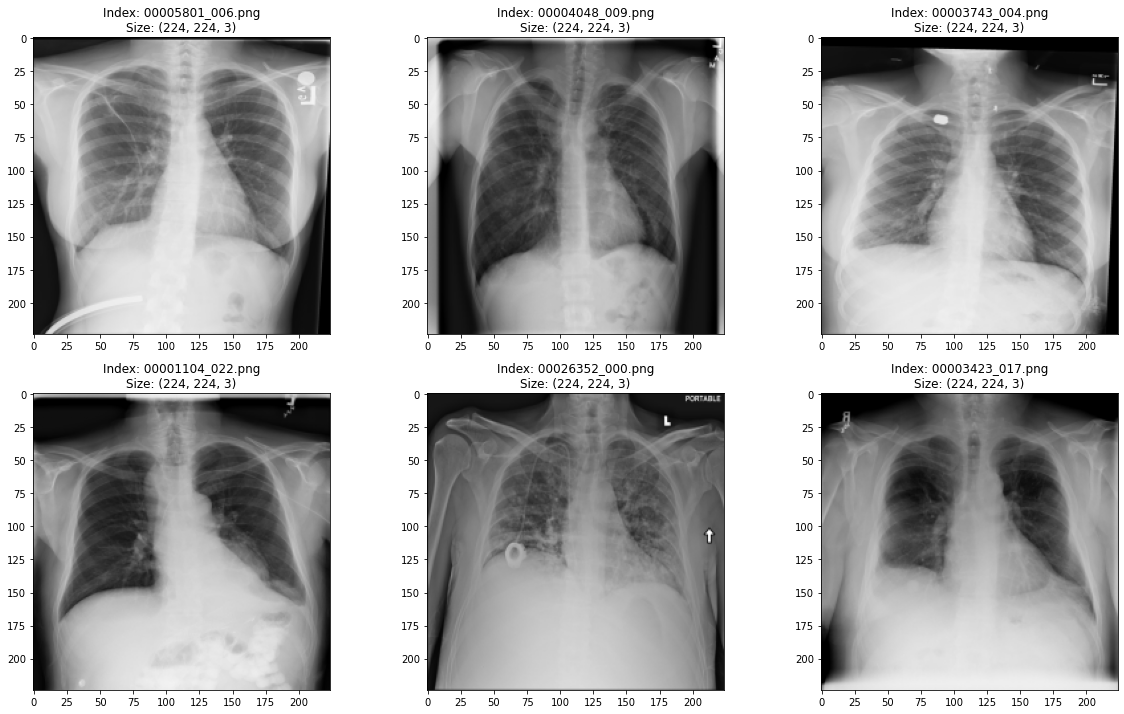

In [8]:
img_path = img_paths[0]
img_file = img_path+'/{}'

# show 6 random images from the train set (first folder only)
fig, axes = plt.subplots(2, 3, figsize = (20, 12))
axes = axes.ravel()

for ax in axes:
    file_name = random.choice(images)
    img = plt.imread(img_file.format(file_name))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Index: {file_name}\nSize: {img.shape}")
    ax.grid(False)

In the dataset ChestX-ray8, X-ray images were directly extracted from the DICOM file and resized as 1024x1024 bitmap images. Their intensity ranges were rescaled using the default window settings stored in the DICOM header files.

## Bounding boxes

#### Now we will look into the data regardng the bounding boxes.

In [9]:
boxes = pd.read_csv(bbox_csv)
boxes.columns

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [10]:
boxes.shape

(984, 9)

In [11]:
# drop the last 3 columns with Nans
boxes.drop(columns=boxes.columns[-3:], inplace=True)
boxes.head()

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  
0   79.186441  
1  313.491525  
2  216.949153  
3   55.322034  
4   78.101695

In [12]:
# rename x and h columns
boxes.rename(columns={'Bbox [x': 'x', 'h]': 'h'}, inplace=True)
boxes.head()

Image Index Finding Label           x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

            h  
0   79.186441  
1  313.491525  
2  216.949153  
3   55.322034  
4   78.101695

In [13]:
# How many images in the train set have a bounding box?
boxes['is_train'] = 1*boxes['Image Index'].isin(list(train_files_list.filename.values))
print(f'{boxes[boxes.is_train==1].shape[0]} images in the train set have a bounding box')

0 images in the train set have a bounding box


#### All the bounding boxes available correspond to images in the test set and hence, we have excluded them from further EDA.

## Loading the data entry file

In [14]:
data = pd.read_csv(data_entry_csv)

In [15]:
print(f'There is data for {data.shape[0]:,} images in the file')

There is data for 112,120 images in the file


In [16]:
data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.168  0.168

In [17]:
# Add column with 1 if the file is in the train set
data['is_train'] = 1*data['Image Index'].isin(list(train_files_list.filename.values))
assert(data.is_train.sum() == train_files_list.shape[0])
data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  is_train  
0                        0.143  0.143         1  
1                        0.143  0.143         1  
2                        0.168  0.168         1  
3                        0.171  0.171         1  
4                        0.168  0.168         0

We loaded the image/patient data file and confirmed that there is a one-to-one correspondence between the data in the file and the actual images. Afterwards, we looked at some of the information.

### Labels

Checking the various possible finding labels

In [18]:
labels =  data.apply(lambda row: row['Finding Labels'].split('|'), axis=1).explode(ignore_index=True).unique()
print(labels)

['Cardiomegaly' 'Emphysema' 'Effusion' 'No Finding' 'Hernia'
 'Infiltration' 'Mass' 'Nodule' 'Atelectasis' 'Pneumothorax'
 'Pleural_Thickening' 'Pneumonia' 'Fibrosis' 'Edema' 'Consolidation']


In [19]:
print(f"Found {len(labels)} unique labels")

Found 15 unique labels


#### Checking observations with more than 1 label

In [20]:
# labels are separated with a "|" - checking nr of observations with a "|" in the Finding Label column
nr_obs_mutiple_labels = len(data[data['Finding Labels'].str.contains('|', regex=False)])
print(f"There are {nr_obs_mutiple_labels:,} with multiple labels, corresponding to {nr_obs_mutiple_labels / len(data):.1%} of the dataset.")

There are 20,796 with multiple labels, corresponding to 18.5% of the dataset.


#### Encode the different labels in the whole dataset

In [21]:
data_labels = data.copy()

In [22]:
for label in labels:
    data_labels[label] = data.apply(lambda row: 1 if label in row['Finding Labels'] else 0, axis = 1)

# Add column for number of findings
data_labels['nr_of_findings'] = data_labels[labels].sum(axis=1)

In [23]:
data_labels.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x  ...  Mass  Nodule  Atelectasis  Pneumothorax  \
0                        0.143  ...     0       0            0             0   
1                        0.143  ...     0       0            0             0   
2                        0.168  ...     0       0            0             0   
3                        0.171  ...     0       0            0             0   
4                        0.168  ...     0       0            0             0   

   Pleural_Thickening  Pneumonia  Fibrosis  Edema  Consolidation  \
0                   0          0         0      0              0   
1                   0          0         0      0              0   
2                   0          0         0      0              0   
3                   0          0         0      0              0   
4                   0          0         0      0              0   

   nr_of_findings  
0               1  
1               2  
2               2  
3               1  
4               1  

[5 rows x 28 columns]

We looked at the labels using the whole dataset. As described above, we found 15 unique labels in the dataset, 14 corresponding to chest pathologies and ‘No Finding’, meaning that no known pathology has been detected

## Separating the train and test set

In [24]:
data_train = data_labels[data_labels.is_train == 1].copy()
data_test = data_labels[data_labels.is_train == 0].copy()

## EDA on the train set

In [25]:
label_cnts = data_train[labels.tolist()].sum()
label_cnts

Cardiomegaly           1707
Emphysema              1423
Effusion               8659
No Finding            50500
Hernia                  141
Infiltration          13782
Mass                   4034
Nodule                 4708
Atelectasis            8280
Pneumothorax           2637
Pleural_Thickening     2242
Pneumonia               876
Fibrosis               1251
Edema                  1378
Consolidation          2852
dtype: int64

Label  Count  % of cases
0         Cardiomegaly   1707    1.633962
1            Emphysema   1423    1.362114
2             Effusion   8659    8.288504
3           No Finding  50500   48.339236
4               Hernia    141    0.134967
5         Infiltration  13782   13.192304
6                 Mass   4034    3.861396
7               Nodule   4708    4.506557
8          Atelectasis   8280    7.925720
9         Pneumothorax   2637    2.524170
10  Pleural_Thickening   2242    2.146071
11           Pneumonia    876    0.838518
12            Fibrosis   1251    1.197473
13               Edema   1378    1.319039
14       Consolidation   2852    2.729970

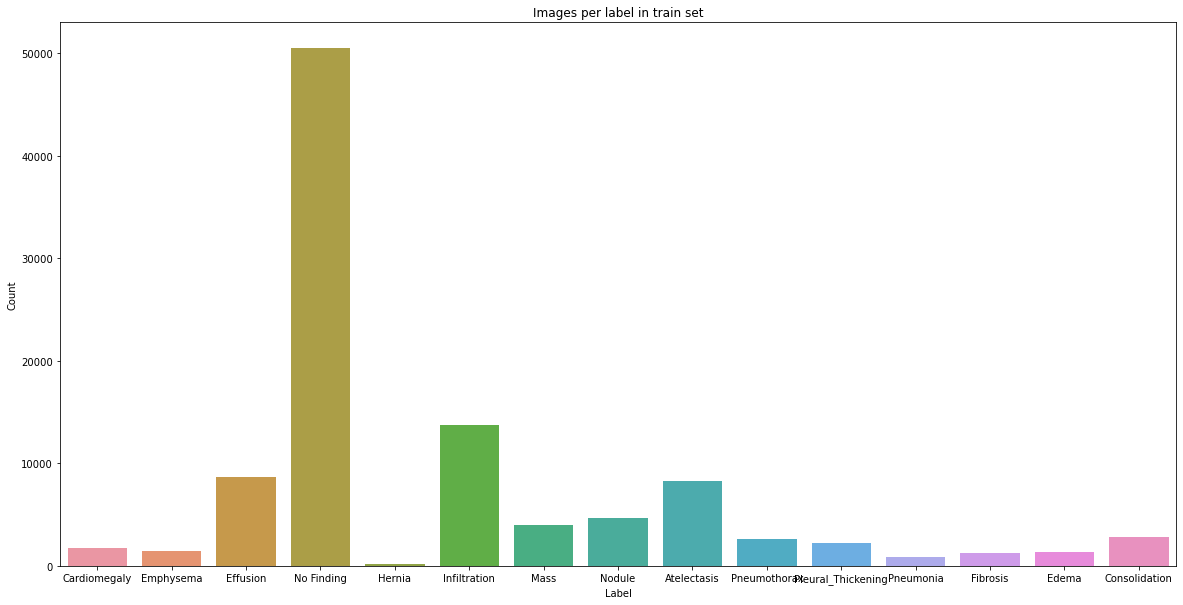

In [26]:
label_cnts_train = data_train[labels.tolist()].sum().reset_index().rename(columns={'index':'Label', 0: 'Count'})
label_cnts_train['% of cases'] = (label_cnts_train.Count/label_cnts_train.Count.sum())*100
display(label_cnts_train)

# Plot
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(
    data=label_cnts_train,
    x='Label',
    y='Count',
    ax=axes
)

axes.set(
    title='Images per label in train set'
)

plt.show()

#### We can see that our train set is not balanced: some labels represent a very small portion of images, while the majority of images is labeled "No finding".

Including combinations of labels would increase the number of classes significantly. We decided that studying combinations of labels in addition to individual labels would contribute further to the class imbalance seen in the graph, so we decided that we should try to predict each label separately. Hence, we did not investigate combinations.

### Correlation matrix between the variables

In [27]:
data_train.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0   00000001_000.png            Cardiomegaly            0           1   
1   00000001_001.png  Cardiomegaly|Emphysema            1           1   
2   00000001_002.png   Cardiomegaly|Effusion            2           1   
3   00000002_000.png              No Finding            0           2   
12  00000004_000.png             Mass|Nodule            0           4   

    Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0            57              M            PA                 2682     2749   
1            58              M            PA                 2894     2729   
2            58              M            PA                 2500     2048   
3            80              M            PA                 2500     2048   
12           82              M            AP                 2500     2048   

    OriginalImagePixelSpacing[x  ...  Mass  Nodule  Atelectasis  Pneumothorax  \
0                         0.143  ...     0       0            0             0   
1                         0.143  ...     0       0            0             0   
2                         0.168  ...     0       0            0             0   
3                         0.171  ...     0       0            0             0   
12                        0.168  ...     1       1            0             0   

    Pleural_Thickening  Pneumonia  Fibrosis  Edema  Consolidation  \
0                    0          0         0      0              0   
1                    0          0         0      0              0   
2                    0          0         0      0              0   
3                    0          0         0      0              0   
12                   0          0         0      0              0   

    nr_of_findings  
0                1  
1                2  
2                2  
3                1  
12               2  

[5 rows x 28 columns]

<AxesSubplot:>

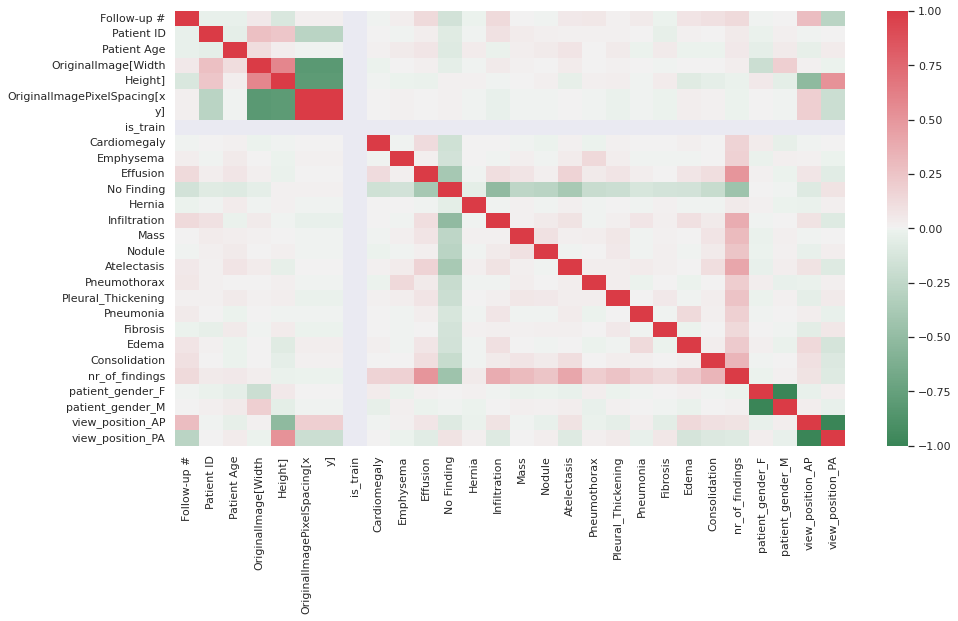

In [28]:
# Get one hot encoding of columns
one_hot_gender_label = pd.get_dummies(data['Patient Gender'], prefix = "patient_gender")
one_hot_position_label = pd.get_dummies(data['View Position'], prefix = "view_position")

# Drop column as it is now encoded
data_correl = data_train.drop('Patient Gender',axis = 1)
data_correl = data_correl.drop('View Position',axis = 1)
# drop image index & finding labels
data_correl = data_correl.drop('Image Index',axis = 1)
data_correl = data_correl.drop('Finding Labels',axis = 1)


# Join the encoded df
data_correl = data_correl.join(one_hot_gender_label)
data_correl = data_correl.join(one_hot_position_label)

# Correl heatmap

cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.set(rc = {'figure.figsize':(15,8)})
corr = data_correl.corr()
sns.heatmap(corr, cmap=cmap)


**The above correlation matrix shows that the predictors are not highly correlated. Only categhorical variables, that are mutually exclusive, are positively/negatively correlated, as expected. As a result, our dataset does not present multicollinearity issues. Additionally, image acquitition parameters (image width/height, pixel spacing) are associated with AP/PA view positioning. This was expected, as different view postions produce images of different quality.**

### Checking distribution of follow-ups

In [29]:
tot_patients = data_train['Patient ID'].nunique()
print(f"Total nr of unique patients: {tot_patients:,}")

followup_perc = (data_train[['Follow-up #', 'Patient ID']].groupby(['Patient ID']).last().value_counts()/tot_patients)*100
followup_perc = followup_perc.sort_values(ascending=False).to_frame().reset_index().rename(columns={0: '% of total'})
followup_perc['% cummulative'] = followup_perc['% of total'].cumsum()

f = 10
print(f'Percentage of patients with follow-up appointments (up to {f})')
followup_perc[:f+1]

Total nr of unique patients: 28,008
Percentage of patients with follow-up appointments (up to 10)


Follow-up #  % of total  % cummulative
0             0   57.590688      57.590688
1             1   13.774636      71.365324
2             2    7.126535      78.491859
3             3    4.438018      82.929877
4             4    3.066981      85.996858
5             5    2.588546      88.585404
6             6    1.988718      90.574122
7             7    1.588832      92.162953
8             8    1.221080      93.384033
9             9    1.013996      94.398029
10           10    0.889032      95.287061

#### We can see that the images are from a unique set of 28,008 patients. For 57% of the patients, there are images of only the first appointment while the remaining 43% patients have images of atleast 1 follow up.

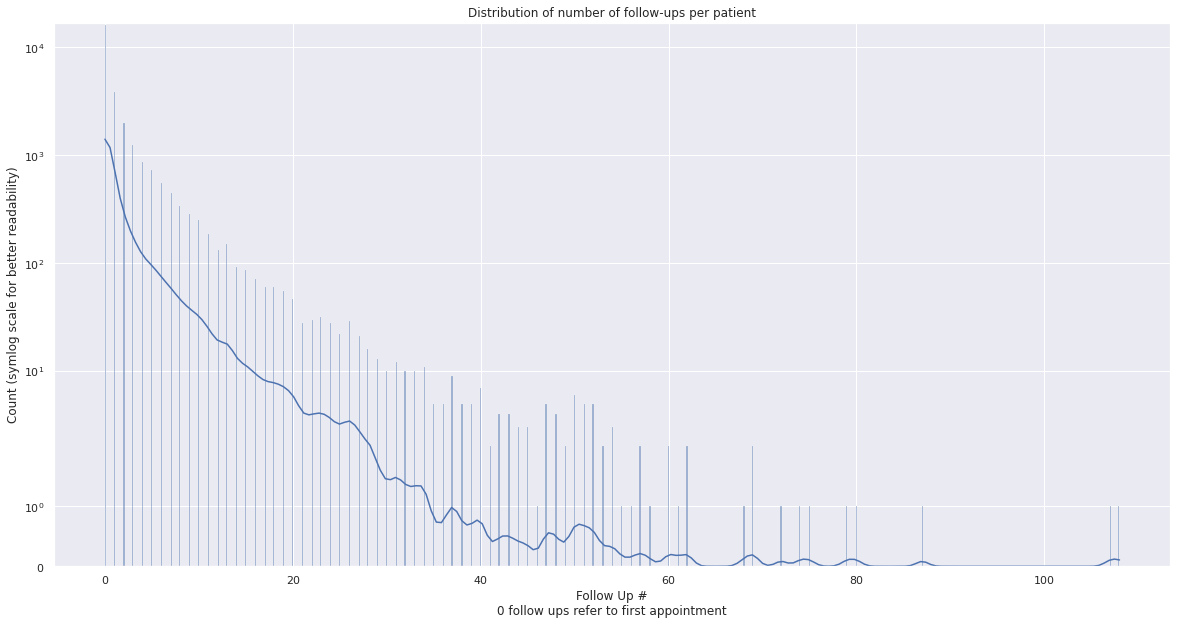

In [30]:
# Distribution of number of follow-up appointments per patient
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.histplot(
    data=data_train[['Follow-up #', 'Patient ID']].groupby(['Patient ID']).last(), 
    x='Follow-up #', 
    kde=True, 
    ax=axes,
)

axes.set(
    title = 'Distribution of number of follow-ups per patient',
    yscale = 'symlog',
    xlabel = 'Follow Up #\n0 follow ups refer to first appointment',
    ylabel = 'Count (symlog scale for better readability)'
)
plt.show()

In [31]:
data_train[["Patient_ID","Patient_Image_Index"]] = data["Image Index"].str.split("_", expand=True)  

In [32]:
data_grouped = (data_train
                .sort_values(by=["Patient_ID","Patient_Image_Index"],ascending=[True,True])
                .groupby("Patient_ID")
                .tail(1)
                )


In [33]:
data_grouped.head()

Image Index         Finding Labels  Follow-up #  Patient ID  \
2   00000001_002.png  Cardiomegaly|Effusion            2           1   
3   00000002_000.png             No Finding            0           2   
12  00000004_000.png            Mass|Nodule            0           4   
20  00000005_007.png  Effusion|Infiltration            7           5   
21  00000006_000.png             No Finding            0           6   

    Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
2            58              M            PA                 2500     2048   
3            80              M            PA                 2500     2048   
12           82              M            AP                 2500     2048   
20           70              F            PA                 2566     2681   
21           81              M            PA                 2500     2048   

    OriginalImagePixelSpacing[x  ...  Atelectasis  Pneumothorax  \
2                         0.168  ...            0             0   
3                         0.171  ...            0             0   
12                        0.168  ...            0             0   
20                        0.143  ...            0             0   
21                        0.168  ...            0             0   

    Pleural_Thickening  Pneumonia  Fibrosis  Edema  Consolidation  \
2                    0          0         0      0              0   
3                    0          0         0      0              0   
12                   0          0         0      0              0   
20                   0          0         0      0              0   
21                   0          0         0      0              0   

    nr_of_findings  Patient_ID  Patient_Image_Index  
2                2    00000001              002.png  
3                1    00000002              000.png  
12               2    00000004              000.png  
20               2    00000005              007.png  
21               1    00000006              000.png  

[5 rows x 30 columns]

In [34]:
data_sm = data_train[["Image Index","Patient Gender", "View Position"]]


************************* Grid Chart of 'Follow-Up Count' Distribution by Finding Label **************************


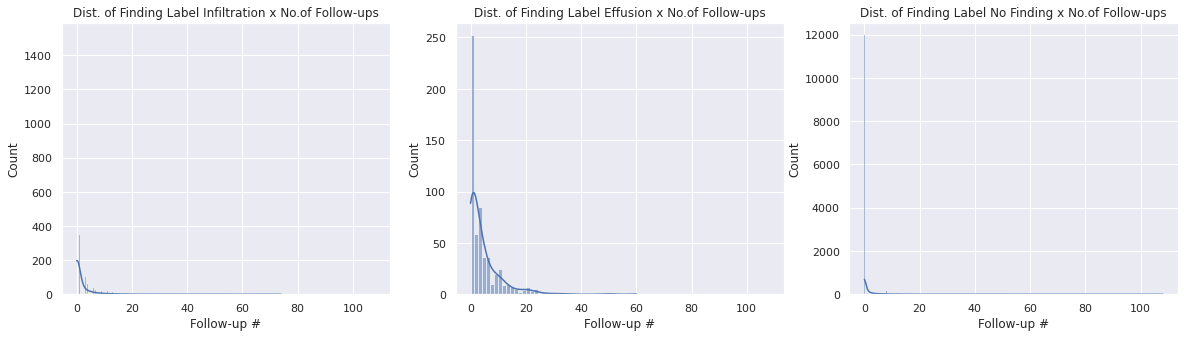

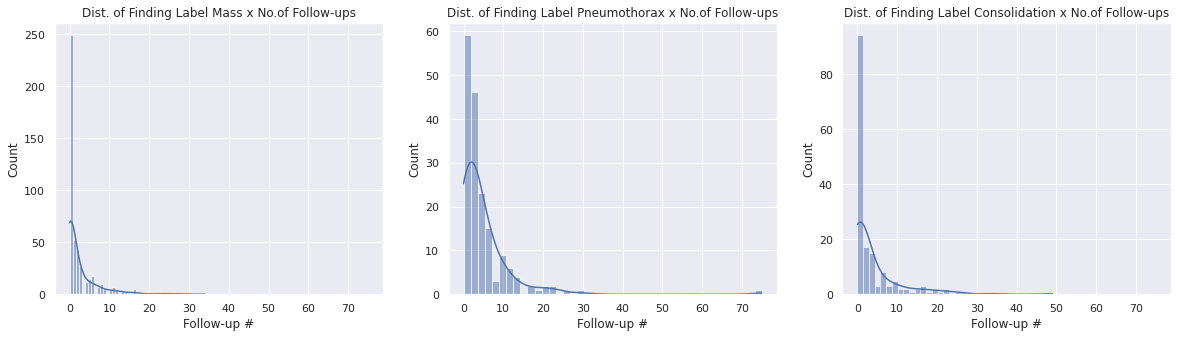

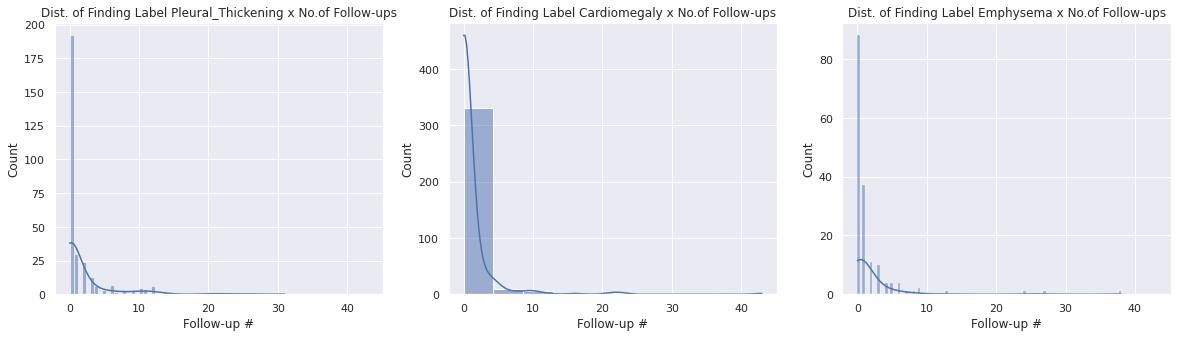

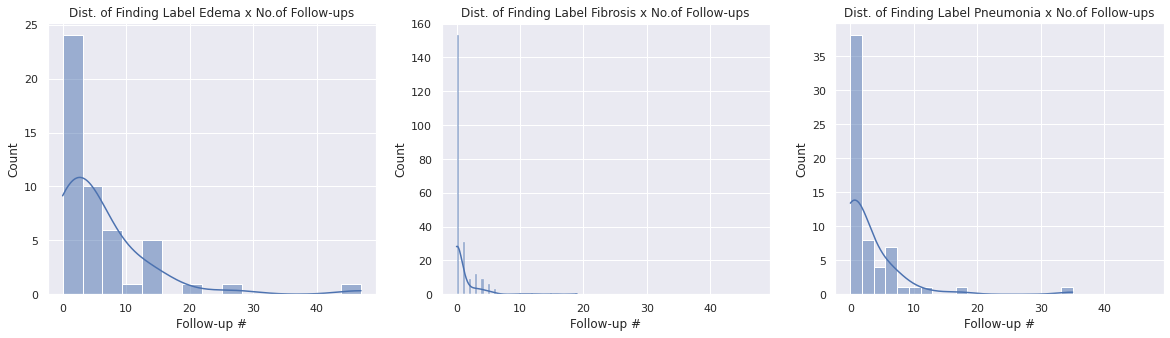

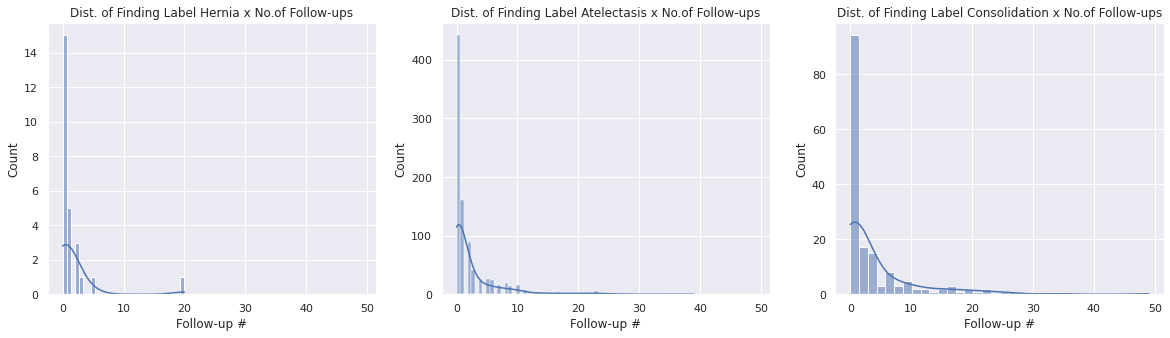

In [35]:
# check age distribution by view

print("\n************************* Grid Chart of 'Follow-Up Count' Distribution by Finding Label **************************")

f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

titles = ["Dist. of Finding Label Infiltration x No.of Follow-ups",
          "Dist. of Finding Label Effusion x No.of Follow-ups",
          "Dist. of Finding Label No Finding x No.of Follow-ups"]
disease = ["Infiltration", "Effusion", "No Finding"]
for i in range(3):
    axes[i].set_title(titles[i])
    sns.histplot(data=data_grouped[data_grouped["Finding Labels"] == disease[i]], x='Follow-up #', kde=True, ax=axes[i])


f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

titles = ["Dist. of Finding Label Mass x No.of Follow-ups",
          "Dist. of Finding Label Pneumothorax x No.of Follow-ups",
          "Dist. of Finding Label Consolidation x No.of Follow-ups"]
disease = ["Mass", "Pneumothorax", "Consolidation"]
for i in range(3):
    axes[i].set_title(titles[i])
    sns.histplot(data=data_grouped[data_grouped["Finding Labels"] == disease[i]], x='Follow-up #', kde=True, ax=axes[i])


f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

titles = ["Dist. of Finding Label Pleural_Thickening x No.of Follow-ups",
          "Dist. of Finding Label Cardiomegaly x No.of Follow-ups",
          "Dist. of Finding Label Emphysema x No.of Follow-ups"]
disease = ["Pleural_Thickening", "Cardiomegaly", "Emphysema"]
for i in range(3):
    axes[i].set_title(titles[i])
    sns.histplot(data=data_grouped[data_grouped["Finding Labels"] == disease[i]], x='Follow-up #', kde=True, ax=axes[i])

    
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

titles = ["Dist. of Finding Label Edema x No.of Follow-ups",
          "Dist. of Finding Label Fibrosis x No.of Follow-ups",
          "Dist. of Finding Label Pneumonia x No.of Follow-ups"]
disease = ["Edema", "Fibrosis", "Pneumonia"]
for i in range(3):
    axes[i].set_title(titles[i])
    sns.histplot(data=data_grouped[data_grouped["Finding Labels"] == disease[i]], x='Follow-up #', kde=True, ax=axes[i])


f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

titles = ["Dist. of Finding Label Hernia x No.of Follow-ups",
          "Dist. of Finding Label Atelectasis x No.of Follow-ups",
          "Dist. of Finding Label Consolidation x No.of Follow-ups"]
disease = ["Hernia", "Atelectasis", "Consolidation"]
for i in range(3):
    axes[i].set_title(titles[i])
    sns.histplot(data=data_grouped[data_grouped["Finding Labels"] == disease[i]], x='Follow-up #', kde=True, ax=axes[i])
    

plt.show()

#### We can see that the number of follow up appointments follows a similar distribution across different labels.

### View Position

Normally, images are acquired with PA positioning (X-ray beam is on the back, detector in the front). AP positioning is the opossite (X-ray beam in the front, detector in the back). PA is used when the patient is not well, and is very commonly used in the ICU. The image quality is inferior with AP positioning, and the images also are different depending on the positioning.

We wanted to investigate if this is reflected in our data.

In [36]:
data_train['View Position'].value_counts()

PA    56214
AP    30310
Name: View Position, dtype: int64

In [37]:
vp_ratio = data_train['View Position'].value_counts()/data_train['View Position'].value_counts().sum()
print(f'{vp_ratio[0]:.2%} of the images were aquired with PA positioning')
print(f'{vp_ratio[1]:.2%} of the images were aquired with AP positioning')

64.97% of the images were aquired with PA positioning
35.03% of the images were aquired with AP positioning


View Position          AP     PA     All
Label                                   
Atelectasis          3913   4367    8280
Cardiomegaly          571   1136    1707
Consolidation        1721   1131    2852
Edema                1180    198    1378
Effusion             3826   4833    8659
Emphysema             549    874    1423
Fibrosis              156   1095    1251
Hernia                 20    121     141
Infiltration         6101   7681   13782
Mass                 1408   2626    4034
No Finding          16003  34497   50500
Nodule               1404   3304    4708
Pleural_Thickening    510   1732    2242
Pneumonia             408    468     876
Pneumothorax          781   1856    2637
All                 38551  65919  104470

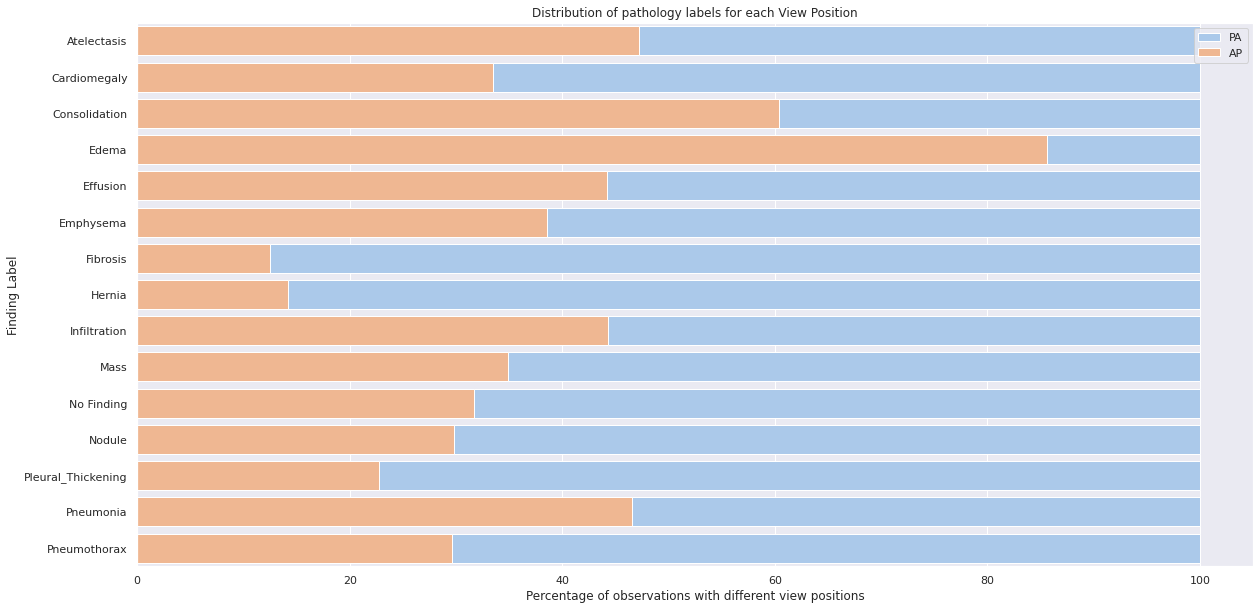

In [38]:
# Distribution of labels per positioning

position_cnts_train = data_train[labels.tolist()+['View Position']].groupby('View Position').sum().stack().reset_index().rename(columns={'level_1':'Label', 0:'Count'})
positions_pivot = pd.pivot_table(position_cnts_train, values='Count', index='Label', columns='View Position', aggfunc=np.sum, margins=True)
display(positions_pivot)

positions_pivot = positions_pivot.div(positions_pivot['All'], axis=0)
positions_pivot = positions_pivot.applymap(lambda x: x*100).reset_index().iloc[:-1]

fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(
    data=positions_pivot,
    x='All',
    y='Label',
    ax=axes,
    label='PA',
    color=sns.color_palette('pastel')[0],
    orient='h'
)

sns.barplot(
    data=positions_pivot,
    x='AP',
    y='Label',
    ax=axes,
    label='AP',
    color=sns.color_palette('pastel')[1],
    orient='h'
)


axes.set(
    title='Distribution of pathology labels for each View Position',
    xlabel='Percentage of observations with different view positions',
    ylabel='Finding Label'
)

axes.legend()

plt.show()

#### It looks like, in general, PA is the most common positioning for most labels. Images that were labeled "Consolidation" and "Edema" were taken with AP positioning, while Pneumonia and Ateleclasis were roughly taken with the same percentage of AP and PA. This could imply that these patients were too unwell for the images to be acquired using PA positioning. We should keep in mind that some images lead to more than one diagnosis, which is not taken into account in this graph.

In [39]:
print('Average number of findings for each position view')
position_cnts_train = data_train[['nr_of_findings','View Position']].groupby('View Position').mean()
display(position_cnts_train)

print('Average number of findings for each position view - for patients with more than 1 finding')
position_cnts_train = data_train[data_train['nr_of_findings']>1][['nr_of_findings','View Position']].groupby('View Position').mean()
display(position_cnts_train)


Average number of findings for each position view


nr_of_findings
View Position                
AP                   1.271890
PA                   1.172644

Average number of findings for each position view - for patients with more than 1 finding


nr_of_findings
View Position                
AP                   2.385042
PA                   2.366324

#### It appears that the number of findings per image is not related to the view position.

### Additional Observations for Patients - Nr, Gender, Age Distribution

In [40]:
# How many men/women in the train set?
pat_ratio = (data_train[['Patient Gender', 'Patient ID']].groupby(['Patient ID']).first().value_counts()/tot_patients)
print(f'{pat_ratio[0]:.2%} of the patients are men')
print(f'{pat_ratio[1]:.2%} of the patients are women')

53.82% of the patients are men
46.18% of the patients are women


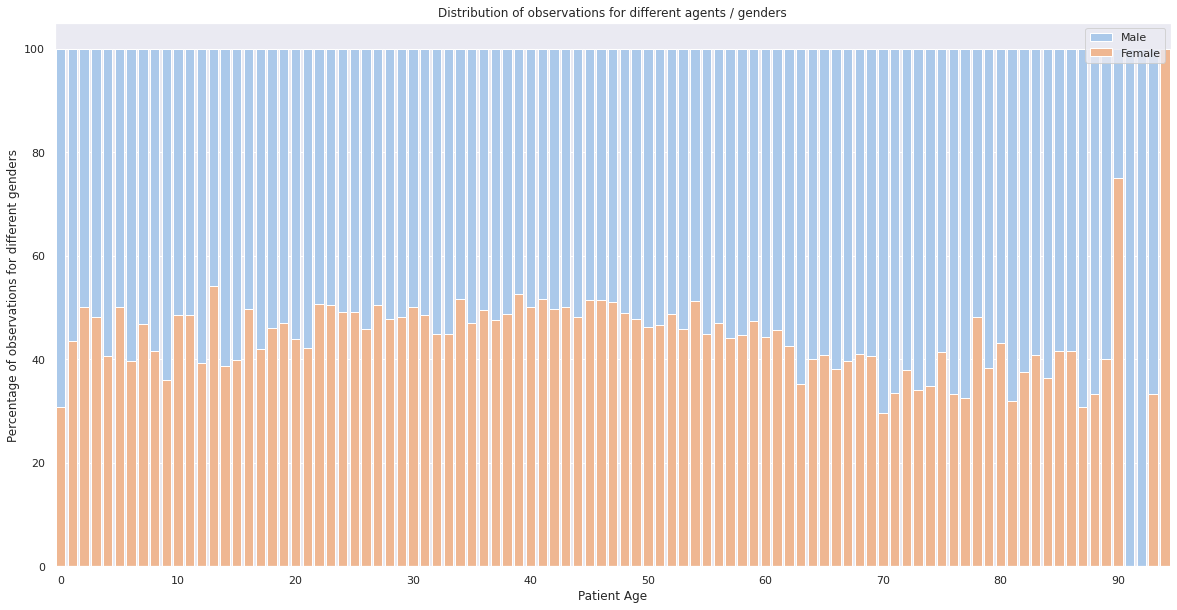

In [41]:
positions_pivot = pd.pivot_table(
    data_train[data_train['Follow-up #']==0][['Patient Age', 'Patient Gender']].reset_index(), 
    index='Patient Age', 
    columns='Patient Gender', 
    aggfunc='count', 
    margins=True,
    fill_value=0
).droplevel(level=0, axis=1)

positions_pivot = positions_pivot.div(positions_pivot['All'], axis=0)
positions_pivot = positions_pivot.applymap(lambda x: x*100).reset_index().iloc[:-1]

fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(
    data=positions_pivot,
    x='Patient Age',
    y='All',
    ax=axes,
    label='Male',
    color=sns.color_palette('pastel')[0],
)

sns.barplot(
    data=positions_pivot,
    x='Patient Age',
    y='F',
    ax=axes,
    label='Female',
    color=sns.color_palette('pastel')[1],
)


axes.set(
    title='Distribution of observations for different agents / genders',
    xlabel='Patient Age',
    ylabel='Percentage of observations for different genders'
)

axes.legend(loc='upper right')

axes.set_xticks(range(positions_pivot['Patient Age'].min(), positions_pivot['Patient Age'].max(), 10))

plt.show()

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Baseline Model: Random Choice
<br />  
    
</div>

#### We have considered 2 approaches to construct a baseline model:

#### 1. Most frequent outome: The most probable outcome in the dataset is that of "No Finding" which occurs in approximately 48% of the observations.
#### 2. Stratified outcome: Another approach would be to make a random draw from the stratified probability distribution of all the labels.

#### Considering that we have 15 labels in the data, we have decided to use the "Random choice based on uniform probability" as the baseline model.

In [42]:
# making a list of all labels
all_labels = ['Cardiomegaly',
       'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
all_labels.sort()

#### In this dataset, every observation can have more than one finding label (on approx. 18% of observations). Hence, any classifier that we build would be required to take this into consideration and may be required to predict more than 1 label for each image. For now, for the purpose of the baseline model, we have chosen to consider each label on an image as an independent observation i.e. if an image has 2 labels assigned to it, we are considering that as 2 different observations with different outcome labels.

In [43]:
# creating x and y sets for train and test data
data_train_exp = data_train.copy()
data_train_exp['True_Findings_Label'] = data_train_exp.apply(lambda row: row['Finding Labels'].split('|'), axis=1)
data_train_exp = data_train_exp.explode('True_Findings_Label', ignore_index=True)

data_test_exp = data_test.copy()
data_test_exp['True_Findings_Label'] = data_test_exp.apply(lambda row: row['Finding Labels'].split('|'), axis=1)
data_test_exp = data_test_exp.explode('True_Findings_Label', ignore_index=True)

x_cols = ['Image Index', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]']
y_col = 'True_Findings_Label'

x_train, x_test = data_train_exp[x_cols].copy(), data_test_exp[x_cols].copy()
y_train, y_test = data_train_exp[y_col].astype('category').cat.codes.copy(), data_test_exp[y_col].astype('category').cat.codes.copy()

all_labels = data_train_exp[y_col].unique().tolist()
all_labels.sort()

#### Fitting baseline model

We evaluated two options for our baseline model. 

- Predict the most probable outcome: The most probable outcome in the train set is "No Finding", which occurs in approximately 48% of the observations.

- Random choice of prediction based on uniform probability: Another approach would be to make a random draw from the probability distribution of all the labels.

Considering that we have 15 labels in the data, we chose to use the latter approach - random choice based on uniform probability. 


In [44]:
baseline_model = DummyClassifier(strategy='stratified')

In [45]:
baseline_model.fit(x_train, y_train)

DummyClassifier(strategy='stratified')

In [46]:
acc = baseline_model.score(x_test, y_test)
print(f"Accuracy of baseline model on test set: {acc:.2%}")

Accuracy of baseline model on test set: 17.92%


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Modeling
<br />  
    
</div>

## Helper Functions

In [47]:
def load_model_wts(model_name, model_params, input_shape, labels):
    """
        Creates a model using a basic model configuration and loads the weights from a stored h5 file
        :param model_name: The name of the model
        :param model_params: Dict containing the specific details of the model to be created
        :param input_shape: tuple with input shape for model
        :param labels: True labels
    """
    sota_model = eval('tf.keras.applications.' + model_params['model'])(
        include_top=False, 
        input_shape=input_shape, 
        pooling='avg'
    )
    x = sota_model.output

    # adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    # and a logistic layer -- with classes = nr_labels
    predictions = Dense(nr_labels, activation='sigmoid')(x)

    # model to train
    model = Model(inputs=sota_model.input, outputs=predictions)
    
    model.load_weights(f"{model_wts_path}{model_name}.h5")
    
    return model

def plot_roc_curves(labels, fpr, tpr, roc_auc):
    """
        Helper function to plot ROC Curve for each label class
    """
    # different line color/style for each label
    color = ['b-', 'g-', 'r-', 'y-', 'm-', 'b:', 'g:', 'r:', 'y:', 'm:', 'b--', 'g--', 'r--', 'y--', 'm--']
    
    for i, c in zip(range(len(labels)), color):
        plt.plot(
            fpr[i],
            tpr[i],
            c,
            label=f"ROC curve of class {labels[i]} (area = {roc_auc[labels[i]]:0.2%})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for each pathology")
    plt.legend(loc="lower right")
    plt.show()
    

def get_performance_metrics(y_true, y_pred, labels, thres = 0.5, plot_curves=True):
    """
        Helper function to get various performance metrics for all labels
        Returns:
            class_rep : The classification report as per sklearn's function
            conf_matrix: Multilabel confusion metrics
            fpr, tpr, thresholds: For ROC curve
            roc_auc: The AUC for each label
            f1_scores: the F1 scores for each 
    """
    # classification report
    class_rep = classification_report(y_true, y_pred>thres, target_names = labels, output_dict=True, zero_division=0)
    conf_matrix = multilabel_confusion_matrix(y_true, 1*(y_pred>thres))

    # roc/auc
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    
    for i in range(len(labels)):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[labels[i]] = auc(fpr[i], tpr[i])
        f1_scores[i] = f1_score(y_true[:, i], (y_pred[:, i] > thres)*1)
        
    if plot_curves:
        plot_roc_curves(labels, fpr, tpr, roc_auc)
        
    return {
        'class_rep': class_rep,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'f1_scores': f1_scores
    }


def tune_threshold(y_true, y_pred, labels, thres = np.arange(0, 1, 0.01)):
    """
        Helper function to get f1 scores at different threshold values for each label
        Objective: Find threshold for each label with maximum F1 score
    """
    f1_scores = {}
    
    mask = np.sum(y_true, axis=1) > 0
    
    for i, l in enumerate(labels):
        f1_scores[l] = {}
        for t in thres:
            f1_scores[l][t] = f1_score(
                y_true[mask, i], 
                y_pred[mask, i]>t,
                zero_division=0
            )
    
    return f1_scores

def calculate_sensitivity_specificity(confusion_matrix):
    """
        Helper function to calculate sensitivity and specificity given the confusion matrix
    """
    sensitivity=[]
    specificity=[]
    for i,_ in enumerate(labels):
        sensitivity.append(confusion_matrix[i][1,1]/(confusion_matrix[i][1,1]+confusion_matrix[i][1,0]))
        specificity.append(confusion_matrix[i][0,0]/(confusion_matrix[i][0,0]+confusion_matrix[i][0,1]))
    return sensitivity, specificity

In [48]:
def make_gradcam_heatmap(imgs, model, last_conv_layer_name, pred_index=None):
    """
        Output the gradcam heatmap
        
        :param imgs: Tf.Dataset that gives the output as expected by the model input
        :param model: The actual model to be used for constructing Gradcam
        :param last_conv_layer_name: The name of the layer which should be used to generate heatmap
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [
            model.get_layer(last_conv_layer_name).output, 
            model.output
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
        
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(imgs)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, ax, alpha=0.4):
    """
        Displays the original image and the heatmap on top of it as an overlap
    """
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # This commented line of code can be uncommented for saving
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    ax.imshow(superimposed_img)

In [49]:
def check_layer_gradients(imgs, model, layer_name, sample_size=8):
    """
        Function to extract the gradients at a given layer and output some basic stats like
        Sum of gradients, Max of gradients, Min of gradients
        Cursory check to see if gradients are zero or non-zero
        
        :param imgs: Tf.Dataset that gives the output as expected by the model input
        :param model: The actual model to be used
        :param layer_name: The name of the layer from which gradients should be extracted
    """
    temp_model = tf.keras.models.Model(
        [model.inputs], 
        [
            model.get_layer(layer_name).output, 
            model.output
        ]
    )
    
    grads = []
    for img, y_label in imgs:
        # get weights from the layer
        g = temp_model(img)[0]
        # add details to list in order: shape of layer, sum of grads, max of grads, min of grads
        grads.append([g.shape, np.sum(g), np.max(g), np.min(g)])
    
    return pd.DataFrame(grads, columns=['Layer Shape', 'Grads_Sum', 'Grads_Max', 'Grads_Min'])
    

## Reading the images and the data

The images are provided in standard size of 1024-by-1024 pixels, with intensities normalized in the range (0,1). To speed up training, we decreased the image size to 224-by-224 pixels, using code provided by our assigned TF, Ivan Shu. As part of the generator we used, we also converted the 1-channel images to 3-channel images, by repeating the same pixel values in 3 layers.

The images were saved in folders depending on which group they belong to: train or test set. To pass the images into the models, we experimented with ImageDataGenerator (tf.keras.preprocessing.image.ImageDataGenerator), as well as tf.data.Dataset.
We found that using ImageDataGenerator resulted in longer training times compared to using tf.data.Dataset. Thus, moving forward we only used tf.data.Dataset instances.

In [50]:
image_files = []

for file in os.listdir(img_resized_dir):
    if '.png' in file:
        image_files.append(file)

len(image_files)

112120

In [51]:
data_df = pd.read_csv(data_entry_csv)
data_df = data_df.sort_values(by='Image Index', ascending=True)

#### Checking that there is an image for each observation in the dataframe

In [52]:
assert len(data_df[data_df['Image Index'].isin(image_files)]) == len(data_df), "Found that some images are not there in the directory!"

#### Setting some variables needed for modeling

In [53]:
img_shape = (224, 224, 3)
batch_size = 256
labels =  data_df.apply(lambda row: row['Finding Labels'].split('|'), axis=1).explode(ignore_index=True).unique()
nr_labels = len(labels)

#### One hot encoding the labels

In [54]:
labels =  data_df.apply(lambda row: row['Finding Labels'].split('|'), axis=1).explode(ignore_index=True).unique()

for label in labels:
    data_df[label] = data_df.apply(lambda row: 1 if label in row['Finding Labels'] else 0, axis = 1)

# Add column for number of findings
data_df['nr_of_findings'] = data_df[labels].sum(axis=1)

In [55]:
# Get one hot encoding of columns
one_hot_gender_label = pd.get_dummies(data_df['Patient Gender'], prefix = "patient_gender")
one_hot_position_label = pd.get_dummies(data_df['View Position'], prefix = "view_position")

# Drop encoded columns
data_df.drop(columns = ['Patient Gender', 'View Position'], inplace=True)

# Join the encoded df
data_df = data_df.join(one_hot_gender_label)
data_df = data_df.join(one_hot_position_label)

#### Separating into train and test set

In [56]:
data_df_train = data_df[data_df['Image Index'].isin(train_files_list['filename'].values)]
data_df_train = data_df_train.sort_values(by='Image Index', ascending=True)
data_df_test = data_df[data_df['Image Index'].isin(test_files_list['filename'].values)]
data_df_test = data_df_test.sort_values(by='Image Index', ascending=True)

In [57]:
print(f"Shape of train dataset - {data_df_train.shape}")
print(f"Shape of test dataset - {data_df_test.shape}")

Shape of train dataset - (86524, 29)
Shape of test dataset - (25596, 29)


#### Checking that there is no data leakage i.e. no overlapping Patients between Train and Test

In [58]:
assert data_df_test.merge(data_df_train, how='inner', on='Patient ID').size == 0, "Data leakage identified, please check!"

## Custom Loss Function (Multi-Task Loss)

In practice, as well as in our dataset, there can be more than one label (pathology) assigned to an image. Thus, we are dealing with a multi-class, multi-label problem. Additionally, since the dataset is not balanced, we needed to ensure that the loss function of our model accounts for the different frequency labels appearing in the dataset. To solve for these, we built a custom loss function.

To deal with the class imbalance, this loss function assigns a different weight to the positive and negative instances of each label, giving higher weight to the less frequent values. To accommodate the requirement of assigning multiple labels per image, we average the weighted loss per class and we aim to minimize the sum of the loss of all classes.

In [59]:
def get_class_frequencies(labels):
    """
        Calculate frequencies for each label
    """
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

In [60]:
positive_frequencies, negative_frequencies = get_class_frequencies(data_df_train[labels].values)
pos_weights = negative_frequencies
neg_weights = positive_frequencies
pos_weights, neg_weights

(array([0.98027137, 0.9835537 , 0.89992372, 0.41634691, 0.99837039,
        0.84071471, 0.9533771 , 0.94558735, 0.90430401, 0.96952291,
        0.97408811, 0.98987564, 0.98554158, 0.98407378, 0.96703805]),
 array([0.01972863, 0.0164463 , 0.10007628, 0.58365309, 0.00162961,
        0.15928529, 0.0466229 , 0.05441265, 0.09569599, 0.03047709,
        0.02591189, 0.01012436, 0.01445842, 0.01592622, 0.03296195]))

In [61]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.
    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.
        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        # cast true values to float else Keras throws an error
        y_true = tf.cast(y_true, dtype=tf.float32)

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += K.mean(-(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon)
                             + neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)))
        return loss

    return weighted_loss

## Testing Keras Applications using Transfer Learning

Instead of creating and training a CNN model from scratch, we decided to use transfer learning and modify already trained, state of the art deep neural networks to suit our task.

The models we chose to train are:
- DenseNet121
- VGG19
- Resnet50
- InceptionV3
- MobileNetV2
- EfficientNetB3

**Approach:** We have trained models with the same architecture, only having different pre-trained CNN model, for a limited number of epochs (5). Then, we have compared the basic metrics for the performance of these models on the test set in order to make an informed choice of the pre-trained model to use.

### Functions to generate Tf.Data.Dataset objects for use in model training, validation and testing

In [62]:
def generate_datasets(image_paths, labels, cat_inputs=np.array([]), seed=25, batch_size=batch_size, 
                    image_size=img_shape[:2], num_channels=3, interpolation='bilinear', crop_to_aspect_ratio=False,
                    shuffle=True):
    """
        Sub-function to return a data set given a list of image paths and associated labels + addl information
        
        :param image_paths: paths to images
        :param labels: list of associated labels for each img
        :param cat_inputs: np array with cat_inputs for each img
        
        length of all inputs should be same as nr of images in directory
        
    """
    

    # generate dataset
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    args = (image_size, num_channels, interpolation, crop_to_aspect_ratio)
    img_ds = path_ds.map(
      lambda x: image_dataset.load_image(x, *args), num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    if len(cat_inputs) > 0:
        cat_ds = tf.data.Dataset.from_tensor_slices(cat_inputs)
        inputs_ds = tf.data.Dataset.zip((img_ds, cat_ds))
        img_ds = tf.data.Dataset.zip((inputs_ds, label_ds))
    else:
        img_ds = tf.data.Dataset.zip((img_ds, label_ds))

    if shuffle:
        img_ds = img_ds.shuffle(buffer_size=batch_size * 8, seed=seed)
    img_ds = img_ds.batch(batch_size)
    return img_ds
        
    

In [63]:
def get_datasets(
    img_dir:str, 
    labels:np.ndarray, 
    cat_inputs:np.ndarray=np.array([]),
    val_split=0.2, 
    seed=109,
    batch_size=batch_size,
    image_size=img_shape[:2],
    num_channels=3,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
    shuffle=True
    ):
    """
        Function to generate a Tf.Dataset based on images in a directory and associated labels
        
        :param img_dir: path to directory with input images, assumed that images are already resized
        :param labels: list of associated labels for each img
        :param cat_inputs: np array with cat_inputs for each img
        
        length of all inputs should be same as nr of images in directory
    """

    # using keras internal method to index directory and get all image paths
    # returns paths and labels already shuffled - marked as False
    image_paths, labels, class_names = dataset_utils.index_directory(
        img_dir,
        list(labels),
        formats='.png',
        class_names=None,
        shuffle=False,
        seed=seed,
        follow_links=False
    )
    
    labels = np.array(labels)
    image_paths = np.array(image_paths)    
    
    if val_split > 0:
        # split into train/test
        # always Shuffle
        tr, val = train_test_split(list(range(len(labels))), test_size=val_split) # have not used random seed here - ??
        
        image_paths_t, image_paths_v = image_paths[tr], image_paths[val]
        labels_t, labels_v = labels[tr], labels[val]
        
        if len(cat_inputs) > 0:
            cat_inputs_t, cat_inputs_v = cat_inputs[tr], cat_inputs[val]
            return (
                generate_datasets(
                    image_paths_t, labels_t, cat_inputs_t, seed, batch_size, 
                    image_size, num_channels, interpolation, crop_to_aspect_ratio,
                    shuffle=True
                ), 
                generate_datasets(
                    image_paths_v, labels_v, cat_inputs_v, seed, batch_size, 
                    image_size, num_channels, interpolation, crop_to_aspect_ratio,
                    shuffle=True
                )
            )
        else:
            return (
                generate_datasets(
                    image_paths_t, labels_t, cat_inputs, seed, batch_size, 
                    image_size, num_channels, interpolation, crop_to_aspect_ratio,
                    shuffle=True
                ), 
                generate_datasets(
                    image_paths_v, labels_v, cat_inputs, seed, batch_size, 
                    image_size, num_channels, interpolation, crop_to_aspect_ratio,
                    shuffle=True
                )
            )
    else:
        # dont split into train and test
            return generate_datasets(
                    image_paths, labels, cat_inputs, seed, batch_size, 
                    image_size, num_channels, interpolation, crop_to_aspect_ratio,
                    shuffle=shuffle
            )

### Creating the train and validation tf.dataset objects

In [64]:
images_train, images_val = get_datasets(
    img_dir=img_resized_train, 
    labels=data_df_train[labels].values
)

Found 86524 files belonging to 1 classes.


In [65]:
print("Completed")

Completed


In [66]:
models = {
    'DenseNet121': {
        'model': 'DenseNet121',
        'preprocess': 'densenet',
    },
    'VGG19': {
        'model': 'VGG19',
        'preprocess': 'vgg19',
    },
    'Resnet50': {
        'model': 'ResNet50V2',
        'preprocess': 'resnet_v2', # need these separately since module name of preprocess methods are different
    },
    'InceptionV3': {
        'model': 'InceptionV3',
        'preprocess': 'inception_v3',
    },
    'MobileNetV2': {
        'model': 'MobileNetV2',
        'preprocess': 'mobilenet_v2',
    },
    'EfficientNetB3': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
    },
}

### Training multiple models for accuracy benchmarking of Keras pre-trained applications on our dataset.

For each of the models, we removed the last layer and added two fully connected layers, as shown in the code below. The output of each model passed through a Dense layer with 256 units, with a dropout rate of 0.5, and then another Dense layer with 256 units. This was the input to the classifier of the model, with 15 units and sigmoid activation.

We used the sigmoid  activation function of the  last fully connected layer, to allow for the prediction of multiple labels. In contrast with softmax, sigmoid activation does not result in predictions with probabilities that add up to 1. We trained each model for 10 epochs, using EarlyStopping with patience=3. We used Adam optimizer, with all the default settings but with learning rate=0.0001. 

To faciliate easier reruns during our testing, we have saved the weights of each of the model we have trained in a h5 file. Additionally, we have also saved the training histories of the models in a pickle file.

In [67]:
epochs = 5
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

model_hists = {}

for model_name, model_params in models.items():
    K.clear_session()
    if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        # we've completed this one... let's keep going
        with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
            model_hists[model_name] = pickle.load(file_pi)
        min_loss_idx = np.argmin(model_hists[model_name]['val_loss'])
        print(f"Skipping {model_name} since this is already completed. Max validation accuracy: {model_hists[model_name]['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")
        continue

    print(f"Starting training with {model_name}")
    
    base_model = eval('tf.keras.applications.' + model_params['model'])(
        include_top=False, 
        input_shape=img_shape, 
        pooling='avg'
    )

    # freeze all convolutional in base_model
    for layer in base_model.layers:
        layer.trainable = False

    # Get output of base model
    # We can simply get the output layer since we have done include_top=False above
    # That ensures that the last layer is the Global Pooling Layer
    x = base_model.output

    # adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    # and a logistic layer -- with classes = nr_labels
    predictions = Dense(nr_labels, activation='sigmoid')(x)

    # model to train
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4), 
        loss=get_weighted_loss(pos_weights, neg_weights), 
        metrics=['accuracy']
    )

    # preprocess train and test sets if required
    if model_params.get('preprocess', False):
        images_train_f = images_train.map(lambda x, y: ( eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)
        images_val_f = images_val.map(lambda x, y: ( eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)
    else:
        images_train_f = images_train
        images_val_f = images_val

    images_train_f = images_train_f.prefetch(1)
    images_val_f = images_val_f.prefetch(1)

    print(f"All ready! Starting fit!")

    hist = model.fit(
      images_train_f,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=images_val_f,
      verbose=True,
      callbacks=[es]
    )
  
    model.save_weights(f"{model_wts_path}{model_name}.h5")
  
    min_loss_idx = np.argmin(hist.history['val_loss'])

    print(f"Completed training of {model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")

    model_hists[model_name] = hist.history
    with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

Skipping DenseNet121 since this is already completed. Max validation accuracy: 42.76% at Epoch Nr 5
Skipping VGG19 since this is already completed. Max validation accuracy: 37.18% at Epoch Nr 5
Skipping Resnet50 since this is already completed. Max validation accuracy: 41.41% at Epoch Nr 5
Skipping InceptionV3 since this is already completed. Max validation accuracy: 38.49% at Epoch Nr 5
Skipping MobileNetV2 since this is already completed. Max validation accuracy: 39.66% at Epoch Nr 5
Skipping EfficientNetB3 since this is already completed. Max validation accuracy: 41.70% at Epoch Nr 5


### Obtaining performance metrics

We have used the test set to generate performance metrics for each of the trained models. For this, we are using the function `get_performance_metrics` (defined above) which returns basic measures like classification report, fpr, tpr, etc.

In [68]:
perf_metrics = {}
f1_scores = {}

images_test_bool = False

for model_name, model_params in models.items():
    filename = f"{model_hist_path}{model_name}_c_report.pkl"
    if os.path.exists(filename):
        # we've completed this one... let's keep going
        with open(filename, 'rb') as file_pi:
            perf_metrics[model_name] = pickle.load(file_pi)
        continue
    
    model = load_model_wts(model_name, model_params, img_shape, labels)
    
    if not images_test_bool:
        # get dataset for test df
        # dont want to create it again and again
        images_test = get_datasets(
            img_dir=img_resized_test, 
            labels=data_df_test[labels].values,
            shuffle=False,
            val_split=0
        )
        images_test_bool = True
    
    y_true = data_df_test[labels].values
    y_pred = model.predict(images_test)
    
    perf_metrics[model_name] = get_performance_metrics(y_true, y_pred, labels, plot_curves=False)
    
    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics[model_name], file_pi)

Additionally, we have computed the sensitivity and specificity for each model.

In [69]:
# calculating sensitivity and specificity for each model
sens_spec = {}

for model_name in models.keys():
    sensitivity, specificity = calculate_sensitivity_specificity(perf_metrics[model_name]['conf_matrix'])

    sens_spec[model_name] = {'sensitivity': sensitivity, 'specificity': specificity}

### Model Selection

To select the best performing model, we compared the validation accuracy and loss, as well as the average weighted precision, 
recall and f1-score. Overall, we were looking to minimize the validation loss and maximize the f1-score, in order to get a balance between recall and precision. The results are shown in the graphs below.

In [70]:
# Dataframe to plot senitivity/specificity per model
sens_spec_df = pd.DataFrame(sens_spec).T.explode(['sensitivity', 'specificity']).reset_index().melt(id_vars=['index'])
sens_spec_df = sens_spec_df.rename(columns={'variable':'metric', 'index':'model'})

# To compare the models, we use the weighted average of the accuracy metrics provided by sklearn.metrics.classification_report
f1_w = dict()

for model_name in models.keys():
    f1_w[model_name] = perf_metrics[model_name]['class_rep']['weighted avg']
    
    min_loss_idx = np.argmin(model_hists[model_name]['val_loss'])
    f1_w[model_name]['val_accuracy'] = model_hists[model_name]['val_accuracy'][min_loss_idx]
    f1_w[model_name]['val_loss'] = model_hists[model_name]['val_loss'][min_loss_idx]
    del f1_w[model_name]['support']

# Dataframe to plot other performance metrics per model
cr_df = pd.DataFrame(f1_w).T.reset_index().melt(id_vars=['index']).rename(columns={'index':'model', 'variable':'metric'})

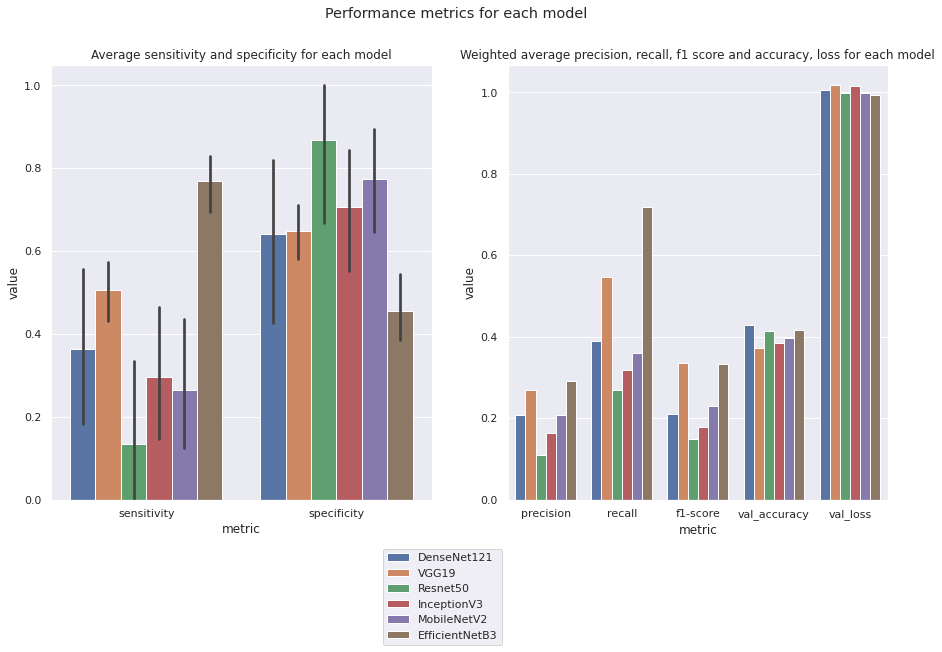

In [71]:
fig, ax = plt.subplots(1,2)
sns.barplot(x="metric", y="value", hue="model", data=sens_spec_df, ax=ax[0])
sns.barplot(x="metric", y="value", hue="model", data=cr_df, ax=ax[1])
ax[0].set(title='Average sensitivity and specificity for each model')
ax[1].set(title='Weighted average precision, recall, f1 score and accuracy, loss for each model')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0,-0.1), loc="upper right")
plt.suptitle('Performance metrics for each model')
plt.show()

From the chart on the right, we can see that all models have validation accuracy of less than 45% and the validation loss is close to 1 for all models.The models with the highest accuracy are VGG19 and EfficientNetB3, with the latter having the lowest validation loss and the highest precision and recall. We can also see that this model also has the highest average sensitivity with the lowest standard deviation among all labels, but also the lowest specificity. Lastly, the graph below shows that EfficientNetB3 has consistently the highest AUC for every label among all pretrained models.

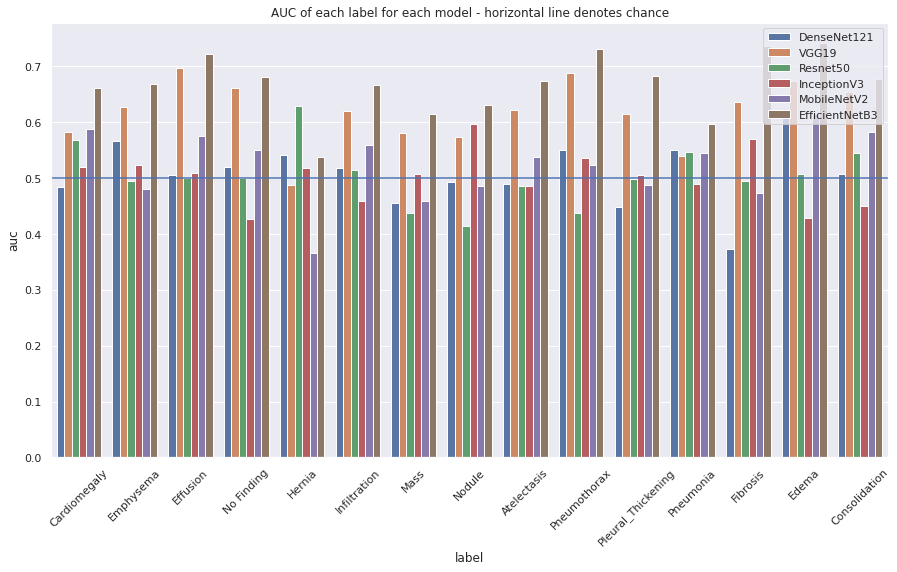

In [72]:
auc_vals = {k:v['roc_auc'] for k, v in perf_metrics.items()}
auc_df = pd.DataFrame(auc_vals).T.reset_index().melt(id_vars='index').rename(columns={'index':'model', 'variable':'label', 'value':'auc'})

bp = sns.barplot(data=auc_df, x='label', y='auc', hue='model')
bp.axhline(0.5)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1,1), loc="upper right")
plt.title('AUC of each label for each model - horizontal line denotes chance')
plt.show()


#### All the models are quite close in terms of accuracy, however, EfficientNetB3 has lowest loss and highest sensitivity, so, we are using that as our base model in further modeling.

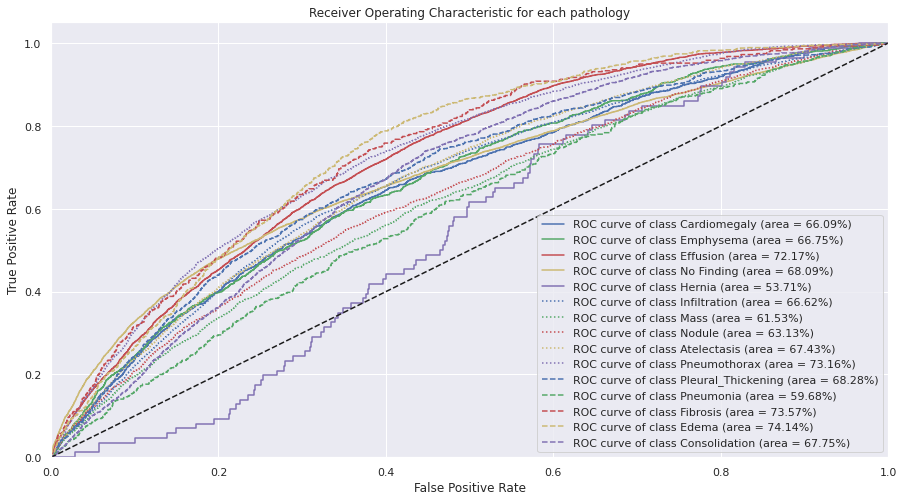

In [73]:
# Plot the ROC curve of each pathology
model_name = 'EfficientNetB3'
plot_roc_curves(
    labels, 
    perf_metrics[model_name]['fpr'], 
    perf_metrics[model_name]['tpr'], 
    perf_metrics[model_name]['roc_auc']
)

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Final Model Architecture & Training
<br />  
    
</div>

After selecting the pretrained model we would use for image classification, we followed several strategies to improve its performance. To train these models, we dropped the ‘No finding’ label (and calculated new class weights) and we changed the last pooling layer of the pretrained model from the default average pooling to max pooling.

In [74]:
base_model_name = 'EfficientNetB3'
base_model_details = models[base_model_name]
base_model_details

{'model': 'EfficientNetB3', 'preprocess': 'efficientnet'}

### Dropping "No Finding" label before final training
Conceptually, if all labels are "0", then that should be "No Finding". Given the way we are training this model (i.e. by using multiple output labels and sigmoid activation + custom loss function), there could be a scenario where the "No Finding" label is also marked as 1 while another pathology is also marked as 1. This is an incorrect scenario and hence, we have chosen to drop this label.

In [75]:
# Drop No Finding from labels
labels = [l for l in labels if l != 'No Finding']
nr_labels = len(labels)

In [76]:
# recompute frequency weights
positive_frequencies, negative_frequencies = get_class_frequencies(data_df_train[labels].values)
pos_weights = negative_frequencies
neg_weights = positive_frequencies
pos_weights, neg_weights

(array([0.98027137, 0.9835537 , 0.89992372, 0.99837039, 0.84071471,
        0.9533771 , 0.94558735, 0.90430401, 0.96952291, 0.97408811,
        0.98987564, 0.98554158, 0.98407378, 0.96703805]),
 array([0.01972863, 0.0164463 , 0.10007628, 0.00162961, 0.15928529,
        0.0466229 , 0.05441265, 0.09569599, 0.03047709, 0.02591189,
        0.01012436, 0.01445842, 0.01592622, 0.03296195]))

### Categorical variables

Our first approach towards improving the model’s performance was to run it for a larger number of epochs.

We then added to this by providing additional information for each image. 

To this end, we trained the model with two additional datasets.

- The first consists of the images and demographic characteristics of the patients (age, gender) and the image’s view position 
- The second expands on the first by adding the true output labels from the previous visit, when available. 

The images were processed by the pretrained model as described in previous section, and the output was passed through a Dense layer with 256 units. The categorical variables were passed through a different Dense layer with 256 units. The outputs of these two Dense layers were then combined into a “Sauce” layer that is trained with the model to weight the information of  the two different inputs. This layer was inspired by the applications of Natural Language Processing in class CS109B. Finally, the output of the “Sauce” layer is passed through a Dense layer with 256 units and Drop out rate of 0.5, and this goes through the classifier layer that will output the probability of each label being assigned to the image.

A visual representation of the models is shown below.


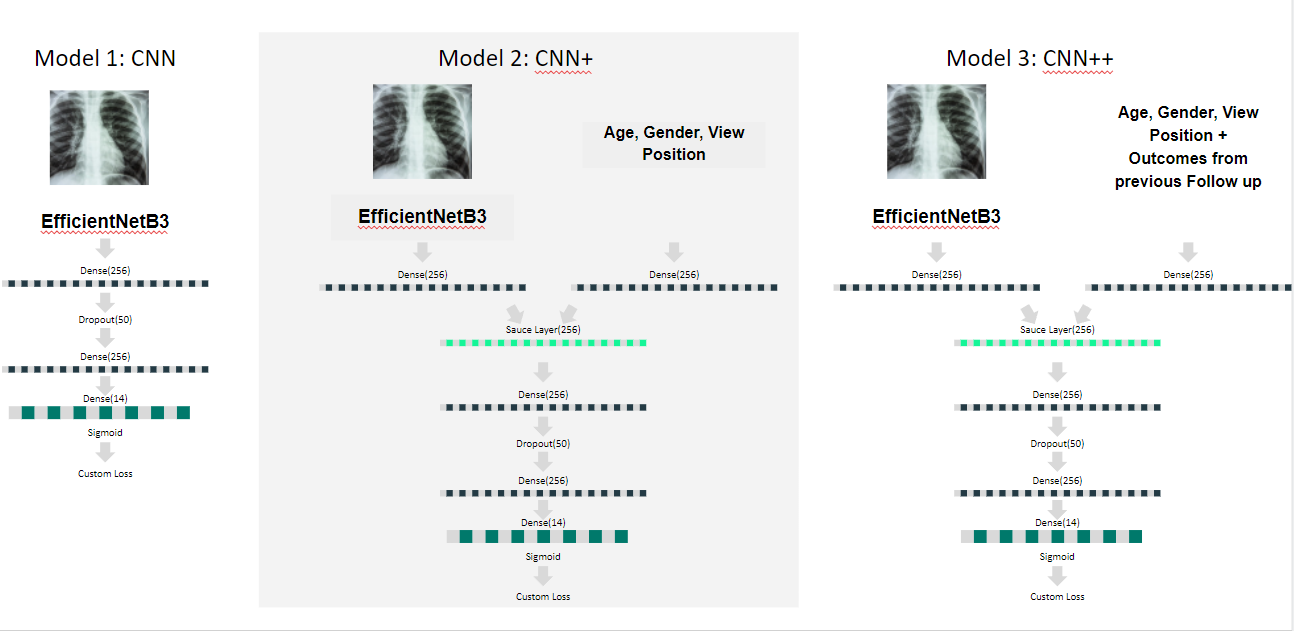

In [77]:
cat_predictors = ['Patient Age', 'patient_gender_M', 'view_position_AP']
cat_df = data_df_train[cat_predictors]
cat_df_test = data_df_test[cat_predictors]

In [78]:
age_scaler = StandardScaler().fit(cat_df[['Patient Age']])

In [79]:
cat_df['Patient Age'] = age_scaler.transform(cat_df[['Patient Age']])
cat_df_test['Patient Age'] = age_scaler.transform(cat_df_test[['Patient Age']])

/tmp/ipykernel_1304/2608170100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Patient Age'] = age_scaler.transform(cat_df[['Patient Age']])
/tmp/ipykernel_1304/2608170100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df_test['Patient Age'] = age_scaler.transform(cat_df_test[['Patient Age']])


In [80]:
cat_df.head()

Patient Age  patient_gender_M  view_position_AP
0      0.623953                 1                 0
1      0.683940                 1                 0
2      0.683940                 1                 0
3      2.003665                 1                 0
12     2.123640                 1                 1

In [81]:
# get the follow up values
follow_up_prev = data_df_train.groupby('Patient ID').shift()[labels].fillna(0)
follow_up_prev_test = data_df_test.groupby('Patient ID').shift()[labels].fillna(0)

In [82]:
cat_df_w_follow = cat_df.merge(follow_up_prev, how='left', left_index=True, right_index=True)
cat_df_test_w_follow = cat_df_test.merge(follow_up_prev_test, how='left', left_index=True, right_index=True)

### Data Augmentation

Another approach we used in an attempt to improve the model’s performance was to train the model without the additional categorical parameters, but with a larger dataset, created by adding augmented images. Instead of randomly selecting images to be augmented, we added images that belong to the least frequent labels, namely Hernia and Pneumonia. In all, we added 422 augmented images for hernia and 480 for pneumonia. 

To generate these images, we used ImageDataGenerator, and applied a random combination of rotation (up to 10 degrees), zooming  (up to 10%) and vertical flipping of the images that were assigned one of these pathologies. To preserve the original labels, we saved the images and stored the filename and the labels in a dataframe, in line with the process used for the original images. The method used for image segmentation and the application on the images labeled with "Hernia" is shown below (the same process was followed for "Pneumonia"). This can be repeated for all pathologies as necessary.


In [83]:
#### Data Augmentation Code: Only run once to generate and save images

# pd.options.display.max_columns = None
# hernia_train_df = data_df_train[data_df_train['Hernia'] == 1]
# hernia_train_df.head()

# hernia_images = hernia_train_df['Image Index'].values
# for image in hernia_images:
#     !cp "../../data/images_resize_train/images/"{image} "../../data/hernia_images"
    
# IMAGE_DIR = "../../data/hernia_images"
# SAVE_DIR = "../../data/hernia_aug_images"

# image_generator = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=0.1,
#     vertical_flip=True
# )

# train_generator = image_generator.flow_from_dataframe(
#                                     hernia_train_df,
#                                     directory=IMAGE_DIR,
#                                     x_col='Image Index',
#                                     y_col=labels,
#                                     target_size=(224, 224),
#                                     color_mode='rgb',
#                                     class_mode='raw',
#                                     batch_size=32,
#                                     shuffle=True,
#                                     seed=109,
#                                 )
# hernia_aug_df = augment_images(train_generator, 'hernia', SAVE_DIR)

##### REPEAT FOR ALL PATHOLOGIES

# aug_df = pd.concat([pneumonia_aug_df, hernia_aug_df]).reset_index()
# aug_df.to_csv('augmented_data.csv', index=False)


In [84]:
# Data augmentation done for 2 categories: Hernia, Pneumonia

df_aug = pd.read_csv('augmented_data.csv') # This was saved in the cell above
data_df_train_aug = pd.concat([data_df_train[['Image Index'] + labels], df_aug], ignore_index=True)
data_df_train_aug = data_df_train_aug.sort_values(by='Image Index', ascending=True)

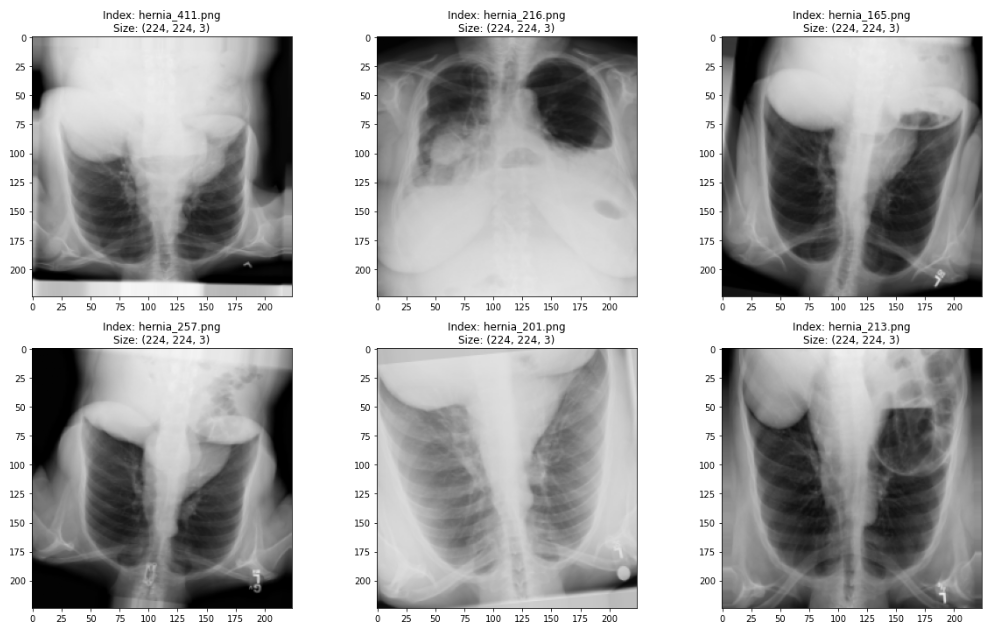

The model trained with the augmented dataset was the model with no categorical variables. It was also trained for 200 epochs with EarlyStopping with patience=5 and min_delta=0.005. The min_delta was added because the model trained for a very long time with practically no variation of the validation loss and no change in the validation accuracy.

#### We created a dict (below) to iterate through different model configurations

In [85]:
# again create a dict to try different model architectures
batch_size = 256
val_split = 0.2

models = {
    f'FinalModel_{base_model_name}_2D_200E': {
        'model': base_model_details['model'],
        'desc': 'CNN, 2 Dense Layers',
        'preprocess': base_model_details['preprocess'],
        'epochs': 200,
        'dense_layers': 2,
        'datasets': get_datasets(img_resized_train, data_df_train[labels].values, batch_size=batch_size, val_split=val_split)
    },
    f'FinalModel_{base_model_name}_2D_200E_C': {
        'model': base_model_details['model'],
        'desc': 'CNN, 2 Dense Layers, 3 Cat Params',
        'preprocess': base_model_details['preprocess'],
        'epochs': 200,
        'dense_layers': 2,
        'cat_predictors': 3,
        'datasets': get_datasets(img_resized_train, data_df_train[labels].values, cat_df.values, batch_size=batch_size, val_split=val_split)
    },
    f'FinalModel_{base_model_name}_2D_200E_C_F': {
        'model': base_model_details['model'],
        'desc': 'CNN, 2 Dense Layers, 3 Cat Params, Follow Up',
        'preprocess': base_model_details['preprocess'],
        'epochs': 200,
        'dense_layers': 2,
        'cat_predictors': 3+len(labels),
        'datasets': get_datasets(img_resized_train, data_df_train[labels].values, cat_df_w_follow.values, batch_size=batch_size, val_split=val_split)
    },
    f'FinalModel_{base_model_name}_2D_200E_DA': {
        'model': base_model_details['model'],
        'desc': 'CNN, 2 Dense Layers, Data Augmentation',
        'preprocess': base_model_details['preprocess'],
        'epochs': 200,
        'dense_layers': 2,
        'datasets': get_datasets(img_resized_train, data_df_train[labels].values, batch_size=batch_size, val_split=val_split)
    },
}

Found 86524 files belonging to 1 classes.
Found 86524 files belonging to 1 classes.
Found 86524 files belonging to 1 classes.
Found 86524 files belonging to 1 classes.


In [86]:
print("Starting training")

Starting training


In [87]:
class SauceLayer(tf.keras.layers.Layer):
    """
        Implementation of ELMO like Sauce layer to integrate outputs from CNN layers (after Pooling)
        and input layers of categorical variables (after activation)
    """
    def __init__(self, **kwargs):
        super(SauceLayer, self).__init__()
        self.supports_masking = True
        
    def build(self, inputs):  # Create the state of the layer (weights)
        self.scale = tf.Variable([0.5,0.5], trainable=True)
        
    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(scale_norm, inputs, axes=1)

In [88]:
def create_model(model_params, img_shape=img_shape, cnn_layers_trainable=False):
    """
        Function to create a model given the model parameters
        Critial model params:
        cat_predictors: Cnt of categorical predictors in dataset.
            If cat predictors are included, they are added to output of CNN layers by using a Sauce Layer
        include_skip: A boolean indicating whether or not to include a residual connection from CNN layer 
            output to Dense layer after the Sauce Layer.
        dense_layers: Nr of dense layers to be included
    """

    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`
    base_model = eval('tf.keras.applications.' + model_params['model'])(
        include_top=False, 
        input_shape=img_shape, 
        pooling='max'
    )

    if not cnn_layers_trainable:
        # freeze all convolutional in base_model
        base_model.trainable = False

    # Get output of base model
    # We can simply get the output layer since we have done include_top=False above
    # That ensures that the last layer is the Global Pooling Layer
    x = base_model.output
        

    ## adding categorical inputs if required
    # using sauce layer to combine inputs
    if model_params.get('cat_predictors', 0) > 0:
        x = Dense(256, activation='relu')(x)
        input_cat = tf.keras.layers.Input(shape=(model_params['cat_predictors']))
        y = Dense(256, activation='relu')(input_cat)
        x = SauceLayer()(tf.stack([x,y]))

        if model_params.get('include_skip', False):
            y = Dense(256, activation='relu')(base_model.output)
            x = Add()([x, y])

        inputs = [base_model.input, input_cat]
    else:
        inputs = base_model.input

    # adding required fully-connected layer
    for _ in range(model_params['dense_layers']):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    # and a logistic layer -- with classes = nr_labels
    predictions = Dense(nr_labels, activation='sigmoid')(x)

    # model to train
    model = Model(inputs=inputs, outputs=predictions)

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(
        optimizer=Adam(learning_rate=1e-3), 
        loss=get_weighted_loss(pos_weights, neg_weights), 
        metrics=['accuracy']
    )
    
    return model

### Model Training

The model was compiled using an Adam optimiser with a learning rate=0.001, using the custom loss function described earlier and trained for 200 epochs, using EarlyStopping with patience = 5.

In [89]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_hists = {}

# batch_size = 32 # 256

for model_name, model_params in models.items():
    K.clear_session()
    if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        # we've completed this one... let's keep going
        with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
            model_hists[model_name] = pickle.load(file_pi)
        print(f"Skipping {model_name} - Loaded weights.")
        continue

    model = create_model(model_params)
    
    # get relevant datasets
    inputs_train = model_params['datasets'][0]
    inputs_val = model_params['datasets'][1]

    # preprocess train and test sets if required
    if model_params.get('cat_predictors', 0) > 0:
        # handle that the input will have an additional array
        func = lambda x, y: ((eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]), x[1]), y)
    else:
        func = lambda x, y: (eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y)

    if model_params.get('preprocess', False):
        inputs_train = inputs_train.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        inputs_val = inputs_val.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        
    inputs_train = inputs_train.prefetch(tf.data.AUTOTUNE)
    inputs_val = inputs_val.prefetch(tf.data.AUTOTUNE)

    print(f"All ready! Starting fit!")

    hist = model.fit(
      inputs_train,
      batch_size=batch_size,
      epochs= model_params['epochs'],
      validation_data=inputs_val,
      verbose=True,
      callbacks=[es]
    )
  
    model.save_weights(f"{model_wts_path}{model_name}.h5")
  
    min_loss_idx = np.argmin(hist.history['val_loss'])

    model_hists[model_name] = hist.history
    with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)
        
    print(f"Completed training of {model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


Skipping FinalModel_EfficientNetB3_2D_200E - Loaded weights.
Skipping FinalModel_EfficientNetB3_2D_200E_C - Loaded weights.
Skipping FinalModel_EfficientNetB3_2D_200E_C_F - Loaded weights.
Skipping FinalModel_EfficientNetB3_2D_200E_DA - Loaded weights.


### Obtaining performance metrics for each model on the test dataset

In [90]:
perf_metrics = {}

for model_name, model_params in models.items():
    filename = f"{model_hist_path}{model_name}_c_report.pkl"
    filename_thresh = f"{model_hist_path}{model_name}_thresh_f1scores.pkl"
    if os.path.exists(filename) and os.path.exists(filename_thresh):
        # we've completed this one... let's keep going
        with open(filename, 'rb') as file_pi:
            perf_metrics[model_name] = pickle.load(file_pi)
        with open(filename_thresh, 'rb') as file_pi:
            f1_scores = pickle.load(file_pi)
        print(f"Loaded {model_name} metrics from pickle file")
        continue
    
    model = create_model(model_params)
    model.load_weights(f"{model_wts_path}{model_name}.h5")
        
    # get dataset for test df
    images_test = get_datasets(
        img_dir=img_resized_test, 
        labels=data_df_test[labels].values,
        cat_inputs = cat_df_test_w_follow.values if model_params.get('cat_predictors', 0) > 3 else cat_df_test.values if model_params.get('cat_predictors', 0) > 0 else np.array([]),
        val_split=0,
        shuffle=False
    )
    
    y_true = data_df_test[labels].values
    y_pred = model.predict(images_test)
    
    perf_metrics[model_name] = get_performance_metrics(y_true, y_pred, labels, plot_curves=False)
    
    # get f1-scores at each threshold
    f1_scores = tune_threshold(y_true, y_pred, labels)
    
    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics[model_name], file_pi)
    with open(filename_thresh, 'wb') as file_pi:
        pickle.dump(f1_scores, file_pi)
        

Loaded FinalModel_EfficientNetB3_2D_200E metrics from pickle file
Loaded FinalModel_EfficientNetB3_2D_200E_C metrics from pickle file
Loaded FinalModel_EfficientNetB3_2D_200E_C_F metrics from pickle file
Loaded FinalModel_EfficientNetB3_2D_200E_DA metrics from pickle file


### Model Comparison and Selection

Using the same metrics as we had used in the previous evaluations, we can see in the graph below that the best performing model among the ones described above was the model with all the categorical parameters (image and patient information, as well as information on the follow up).

In [91]:
# calculating sensitivity and specificity for each model
sens_spec = {}

for model_name in models.keys():
    sensitivity, specificity = calculate_sensitivity_specificity(perf_metrics[model_name]['conf_matrix'])

    sens_spec[model_name] = {'sensitivity': sensitivity, 'specificity': specificity}

In [92]:
# Dataframe to plot senitivity/specificity per model
sens_spec_df = pd.DataFrame(sens_spec).T.explode(['sensitivity', 'specificity']).reset_index().melt(id_vars=['index'])
sens_spec_df = sens_spec_df.rename(columns={'variable':'metric', 'index':'model'})

# To compare the models, we use the weighted average of the accuracy metrics provided by sklearn.metrics.classification_report
f1_w = dict()

for model_name in models.keys():
    f1_w[model_name] = perf_metrics[model_name]['class_rep']['weighted avg']
    
    min_loss_idx = np.argmin(model_hists[model_name]['val_loss'])
    f1_w[model_name]['val_accuracy'] = model_hists[model_name]['val_accuracy'][min_loss_idx]
    f1_w[model_name]['val_loss'] = model_hists[model_name]['val_loss'][min_loss_idx]
    if 'support' in  f1_w[model_name]:
        del f1_w[model_name]['support']

# Dataframe to plot other performance metrics per model
cr_df = pd.DataFrame(f1_w).T.reset_index().melt(id_vars=['index']).rename(columns={'index':'model', 'variable':'metric'})

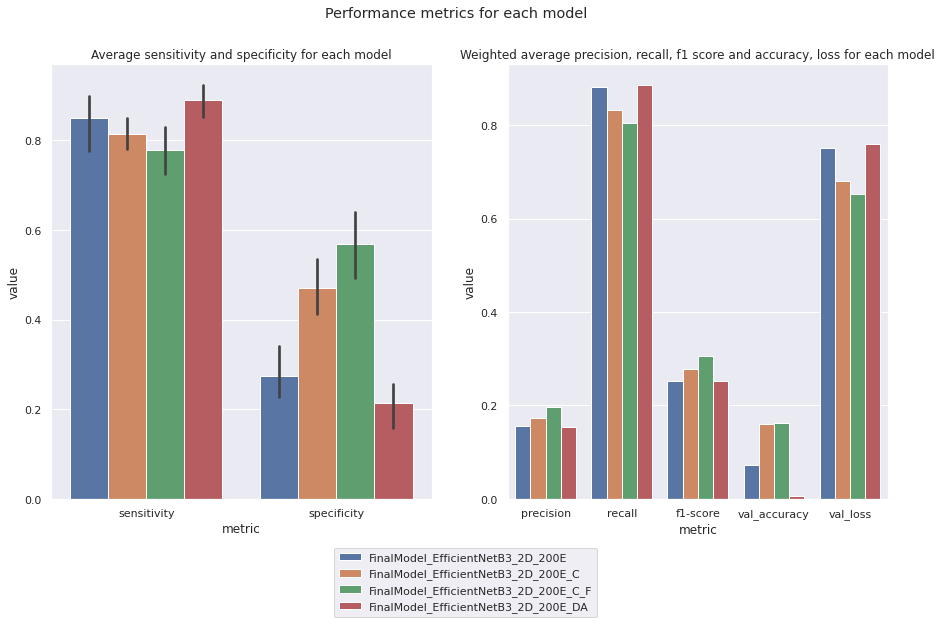

In [93]:
fig, ax = plt.subplots(1,2)
sns.barplot(x="metric", y="value", hue="model", data=sens_spec_df, ax=ax[0])
sns.barplot(x="metric", y="value", hue="model", data=cr_df, ax=ax[1])
ax[0].set(title='Average sensitivity and specificity for each model')
ax[1].set(title='Weighted average precision, recall, f1 score and accuracy, loss for each model')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.25,-0.1), loc="upper right")
plt.suptitle('Performance metrics for each model')
plt.show()

Selecting model with all 17 extra variables (i.e. Age, Gender, View Position and 14 labels based on outcome from previous appointment) based on high sensitivity and lowest loss.

We will now try to interpret the efficacy of the model by checking the Gradcam maps.

In [94]:
sel_model_name = f'FinalModel_{base_model_name}_2D_200E_C_F'

sel_model = models[sel_model_name]
sel_model

{'model': 'EfficientNetB3',
 'desc': 'CNN, 2 Dense Layers, 3 Cat Params, Follow Up',
 'preprocess': 'efficientnet',
 'epochs': 200,
 'dense_layers': 2,
 'cat_predictors': 17,
 'datasets': (<BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>,
  <BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>)}

### Threshold Tuning for Predictions: Maximize F1 Score

Since the models have low precision and high recall, which means that there are many false positives (precision) and few  false negatives (recall). We believe that this is due to the low threshold we apply to classify the predictions (0.5 for all labels). Thus, we decided to calculate more appropriate thresholds, different for each label. To achieve this, we aimed to maximize the f1-score for each label. The resulting thresholds (shown below) are in the range between 0.53 and 0.92, thus, larger than 0.5.

In [95]:
filename_thresh = f"{model_hist_path}{sel_model_name}_thresh_f1scores.pkl"
with open(filename_thresh, 'rb') as file_pi:
    f1_scores = pickle.load(file_pi)

In [96]:
thresh_by_cat = {k:np.array(list(v.values())).argmax()/100 for k, v in f1_scores.items()}

In [97]:
pd.DataFrame.from_dict(thresh_by_cat, orient='index', columns=['Threshold'])

Threshold
Cardiomegaly             0.70
Emphysema                0.93
Effusion                 0.68
Hernia                   0.82
Infiltration             0.53
Mass                     0.74
Nodule                   0.69
Atelectasis              0.61
Pneumothorax             0.89
Pleural_Thickening       0.74
Pneumonia                0.74
Fibrosis                 0.79
Edema                    0.85
Consolidation            0.81

### Checking Model Interpretation Using Gradcam

Armed with the final model and thresholds, we conducted an investigation of the model results by using Grad-cam overlays to understand the areas of the images having the most impact on the predictions.

In [98]:
cat_preds_test = cat_df_test_w_follow.values if sel_model.get('cat_predictors', 0) > 3 else cat_df_test.values if sel_model.get('cat_predictors', 0) > 0 else np.array([])

In [99]:
idx = []
for l in labels:
    idx.append(data_df_test[data_df_test[l] == 1].sample().index.to_list()[0])

In [100]:
df_sample = data_df_test.loc[idx][['Image Index', 'Finding Labels'] + labels]

In [101]:
img_paths = df_sample.apply(lambda x: f"{img_resized_test}/images/{x['Image Index']}", axis=1).values
y_labels = df_sample[labels].values

In [102]:
# create dataset
gradcam_ds = generate_datasets(
    img_paths, 
    y_labels,
    cat_preds_test,
    batch_size=1,
    shuffle=False
)

In [103]:
sel_model

{'model': 'EfficientNetB3',
 'desc': 'CNN, 2 Dense Layers, 3 Cat Params, Follow Up',
 'preprocess': 'efficientnet',
 'epochs': 200,
 'dense_layers': 2,
 'cat_predictors': 17,
 'datasets': (<BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>,
  <BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>)}

In [104]:
# create the model and load the weights
model = create_model(sel_model)
model.load_weights(f"{model_wts_path}{sel_model_name}.h5")

In [105]:
# get last convolutional layer of functional layer
last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
last_conv_layer

'top_conv'

In [106]:
y_preds = model.predict(gradcam_ds)

2022-05-07 21:12:40.700656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-07 21:12:41.401041: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


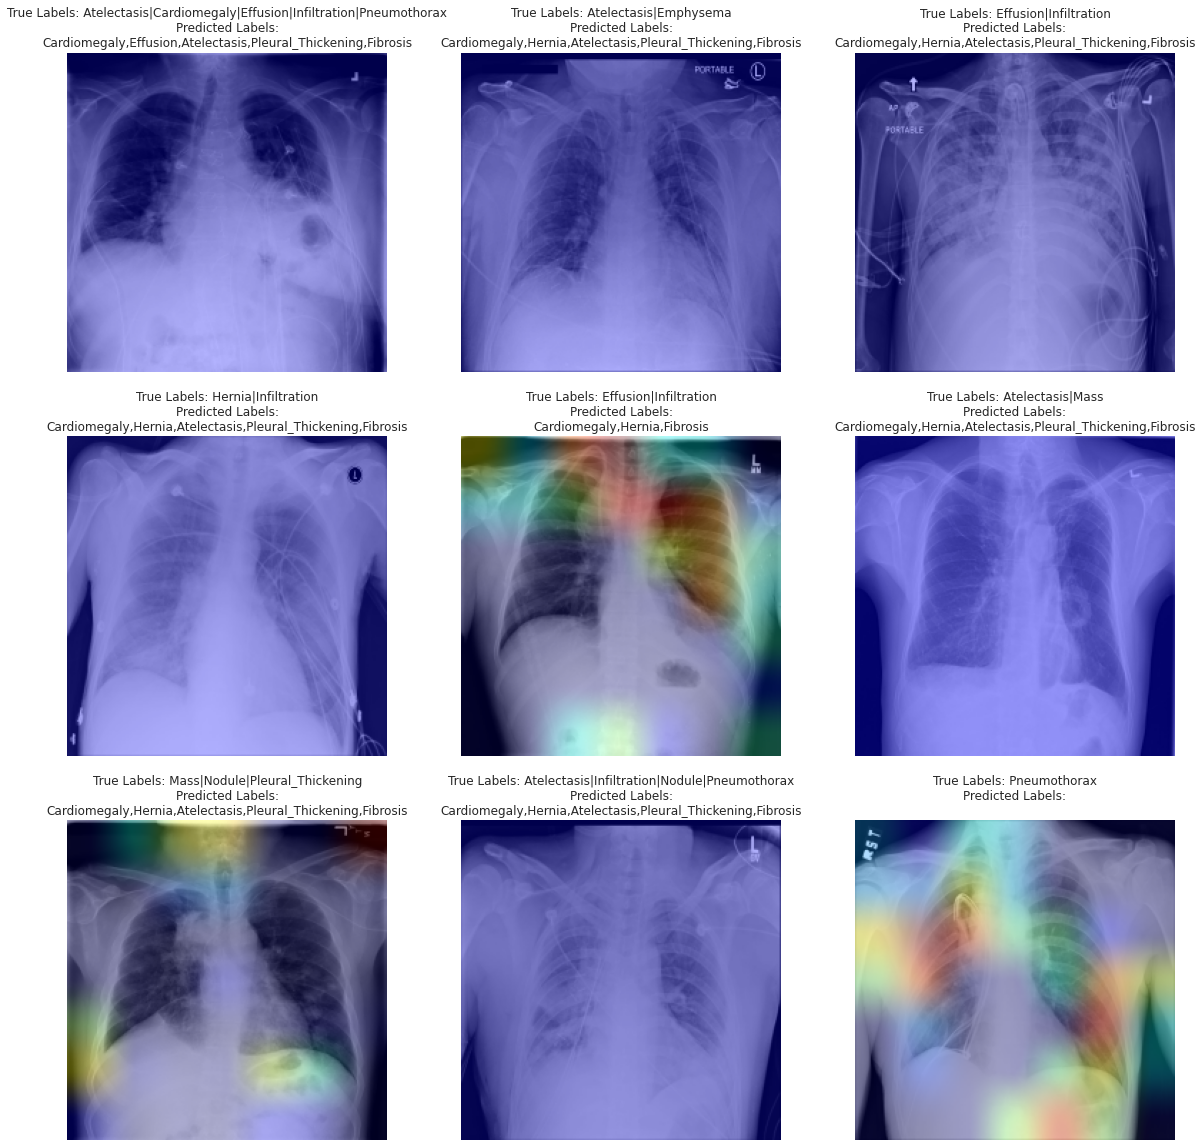

In [107]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

i = 0
for gradcam_imgs, gradcam_y_labels in gradcam_ds.take(9):
    # get heatmap
    hm = make_gradcam_heatmap(gradcam_imgs, model, last_conv_layer)
    img_df = df_sample.iloc[i]
    
    display_gradcam(img_paths[i], hm, axes[i])
    axes[i].grid(False)
    
    axes[i].axis('off')
    
    axes[i].set_title(f"True Labels: {df_sample.iloc[i]['Finding Labels']}\nPredicted Labels:\n{','.join(np.array(labels)[y_preds[i] > list(thresh_by_cat.values())])}")
    
    i += 1


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

### Observation
<br />
    
    We noticed that, in a lot of cases, there are no gradients recorded in the last CNN layer - this is apparent from the fact that the GradCam heatmaps have not highlighted any areas of the images.
    
    To resolve this, we decided to retrain the model using a residual layer connection from the CNN outputs to skip the Sauce Layer thereby enabling better flow of gradients.

</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Retraining model with change in architecture
<br />
    
    Adding a residual layer from last layer of CNN for easier flow of gradients
    
</div>

To improve the flow of gradients in the model, we upgraded the architecture of the model to include a residual connection from the last CNN layer (the max pooling layer) while skipping the Sauce layer. Hence, our final model architecture became as follows

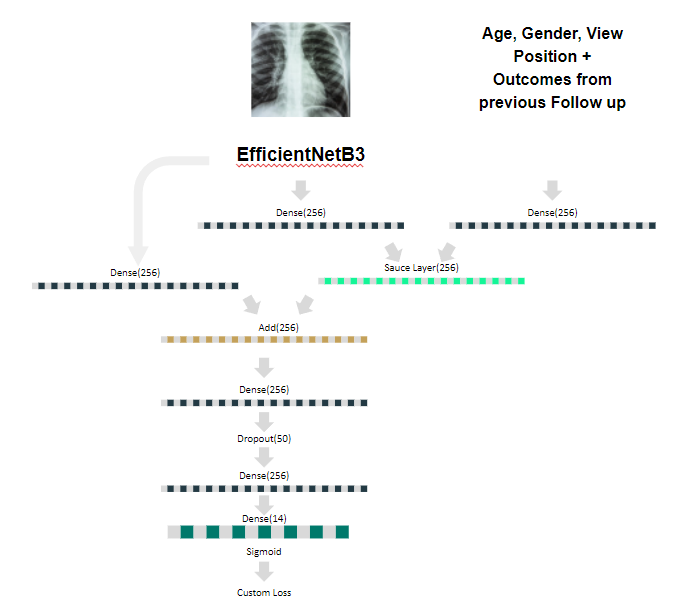

### Model Training

In [108]:
sel_model_name = f'FinalModel_{base_model_name}_2D_200E_C_F'

new_model_name = f'FinalModel_{base_model_name}_2D_200E_C_F_Skip'

models[new_model_name] = models[sel_model_name].copy()
models[new_model_name]['include_skip'] = True

new_model = models[new_model_name]
new_model

{'model': 'EfficientNetB3',
 'desc': 'CNN, 2 Dense Layers, 3 Cat Params, Follow Up',
 'preprocess': 'efficientnet',
 'epochs': 200,
 'dense_layers': 2,
 'cat_predictors': 17,
 'datasets': (<BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>,
  <BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>),
 'include_skip': True}

In [109]:
model = create_model(new_model)

In [110]:
cat_preds_train = cat_df_w_follow.values if new_model.get('cat_predictors', 0) > 3 else cat_df.values if new_model.get('cat_predictors', 0) > 0 else np.array([])

In [111]:
K.clear_session()
if os.path.exists(f"{model_hist_path}{new_model_name}.pkl"):
    # we've completed this one... let's keep going
    with open(f"{model_hist_path}{new_model_name}.pkl", 'rb') as file_pi:
        model_hists[new_model_name] = pickle.load(file_pi)
    print(f"Skipping {new_model_name}: Loaded weights from h5 file.")
else:
    # get relevant datasets
    inputs_train = new_model['datasets'][0]
    inputs_val = new_model['datasets'][1]

    # preprocess train and test sets if required
    if new_model.get('cat_predictors', 0) > 0:
        # handle that the input will have an additional array
        func = lambda x, y: ((eval('tf.keras.applications.' + new_model['preprocess'] + '.preprocess_input')(x[0]), x[1]), y)
    else:
        func = lambda x, y: (eval('tf.keras.applications.' + new_model['preprocess'] + '.preprocess_input')(x), y)

    if new_model.get('preprocess', False):
        inputs_train = inputs_train.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        inputs_val = inputs_val.map(func, num_parallel_calls=tf.data.AUTOTUNE)

    inputs_train = inputs_train.prefetch(tf.data.AUTOTUNE)
    inputs_val = inputs_val.prefetch(tf.data.AUTOTUNE)

    print(f"All ready! Starting fit!")
    # model.summary()
    hist = model.fit(
      inputs_train,
      batch_size=batch_size,
      epochs=new_model['epochs'],
      validation_data=inputs_val,
      verbose=True,
      callbacks=[es]
    )

    model_hists[new_model_name] = hist.history
    
    model.save_weights(f"{model_wts_path}{new_model_name}.h5")

    min_loss_idx = np.argmin(hist.history['val_loss'])

    with open(f"{model_hist_path}{new_model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

    print(f"Completed training of {new_model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


Skipping FinalModel_EfficientNetB3_2D_200E_C_F_Skip: Loaded weights from h5 file.


In [112]:
cat_preds_test = cat_df_test_w_follow.values if new_model.get('cat_predictors', 0) > 3 else cat_df_test.values if new_model.get('cat_predictors', 0) > 0 else np.array([])

In [113]:
filename = f"{model_hist_path}{new_model_name}_c_report.pkl"
filename_thresh = f"{model_hist_path}{new_model_name}_thresh_f1scores.pkl"
if os.path.exists(filename) and os.path.exists(filename_thresh):
    # we've completed this one... let's keep going
    with open(filename, 'rb') as file_pi:
        perf_metrics[new_model_name] = pickle.load(file_pi)
    with open(filename_thresh, 'rb') as file_pi:
        f1_scores = pickle.load(file_pi)
    print(f"Loaded {new_model_name} metrics from pickle file")
else:
    # get dataset for test df
    images_test = get_datasets(
        img_dir=img_resized_test, 
        labels=data_df_test[labels].values,
        cat_inputs = cat_preds_test,
        val_split=0,
        shuffle=False
    )
    
    y_true = data_df_test[labels].values
    y_pred = model.predict(images_test)
    
    perf_metrics[new_model_name] = get_performance_metrics(y_true, y_pred, labels, plot_curves=False)
    
    # get f1-scores at each threshold
    f1_scores = tune_threshold(y_true, y_pred, labels)
    
    # store both files
    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics[new_model_name], file_pi)
    with open(filename_thresh, 'wb') as file_pi:
        pickle.dump(f1_scores, file_pi)

Loaded FinalModel_EfficientNetB3_2D_200E_C_F_Skip metrics from pickle file


### Model Comparison with Previous Models

In [114]:
# calculating sensitivity and specificity for each model
sens_spec = {}

for model_name in models.keys():
    sensitivity, specificity = calculate_sensitivity_specificity(perf_metrics[model_name]['conf_matrix'])

    sens_spec[model_name] = {'sensitivity': sensitivity, 'specificity': specificity}

In [115]:
# Dataframe to plot senitivity/specificity per model
sens_spec_df = pd.DataFrame(sens_spec).T.explode(['sensitivity', 'specificity']).reset_index().melt(id_vars=['index'])
sens_spec_df = sens_spec_df.rename(columns={'variable':'metric', 'index':'model'})

# To compare the models, we use the weighted average of the accuracy metrics provided by sklearn.metrics.classification_report
f1_w = dict()

for model_name in models.keys():
    f1_w[model_name] = perf_metrics[model_name]['class_rep']['weighted avg']
    
    min_loss_idx = np.argmin(model_hists[model_name]['val_loss'])
    f1_w[model_name]['val_accuracy'] = model_hists[model_name]['val_accuracy'][min_loss_idx]
    f1_w[model_name]['val_loss'] = model_hists[model_name]['val_loss'][min_loss_idx]
    if 'support' in  f1_w[model_name]:
        del f1_w[model_name]['support']

# Dataframe to plot other performance metrics per model
cr_df = pd.DataFrame(f1_w).T.reset_index().melt(id_vars=['index']).rename(columns={'index':'model', 'variable':'metric'})

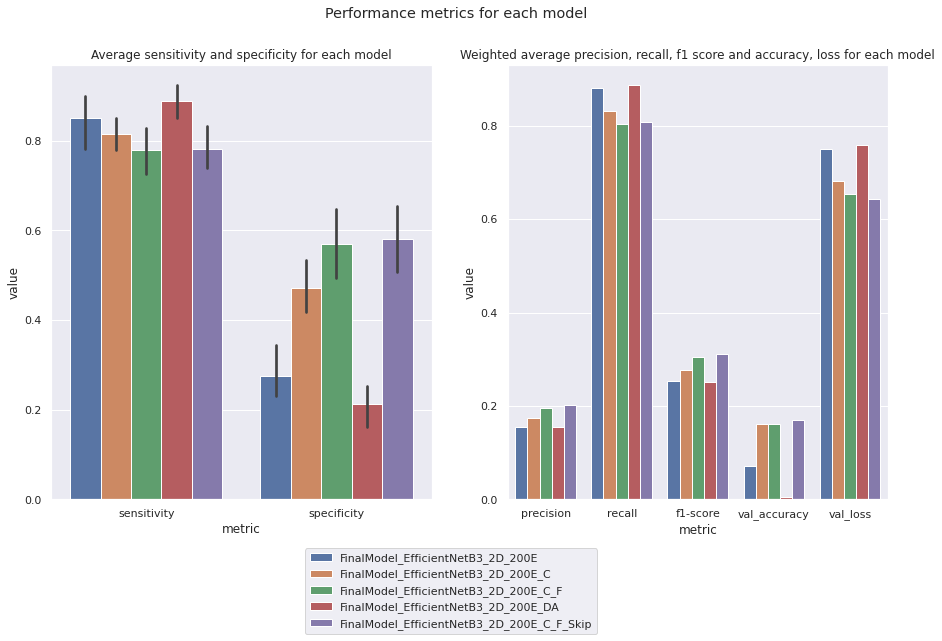

In [116]:
fig, ax = plt.subplots(1,2)
sns.barplot(x="metric", y="value", hue="model", data=sens_spec_df, ax=ax[0])
sns.barplot(x="metric", y="value", hue="model", data=cr_df, ax=ax[1])
ax[0].set(title='Average sensitivity and specificity for each model')
ax[1].set(title='Weighted average precision, recall, f1 score and accuracy, loss for each model')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.25,-0.1), loc="upper right")
plt.suptitle('Performance metrics for each model')
plt.show()

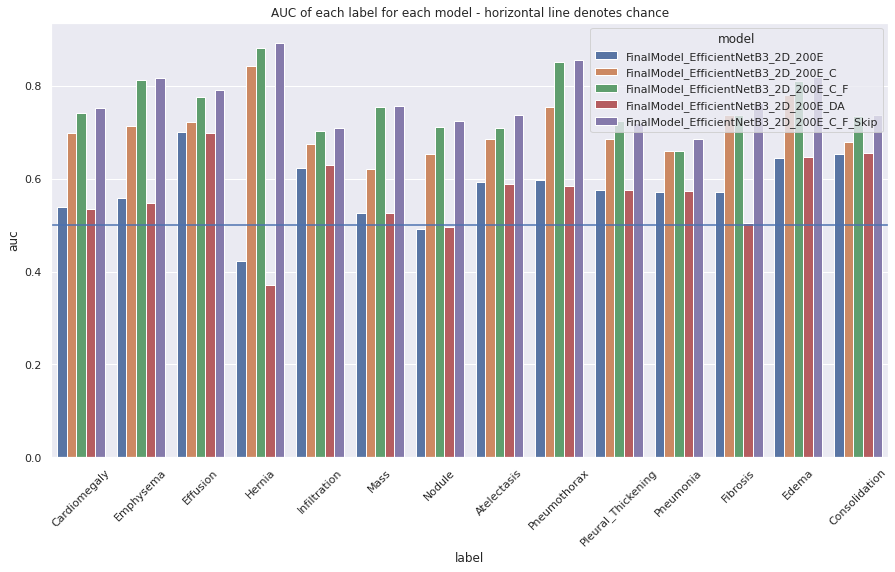

In [117]:
auc_vals = {k:v['roc_auc'] for k, v in perf_metrics.items()}
auc_df = pd.DataFrame(auc_vals).T.reset_index().melt(id_vars='index').rename(columns={'index':'model', 'variable':'label', 'value':'auc'})

bp = sns.barplot(data=auc_df, x='label', y='auc', hue='model')
bp.axhline(0.5)
plt.xticks(rotation=45)
plt.title('AUC of each label for each model - horizontal line denotes chance')
plt.show()


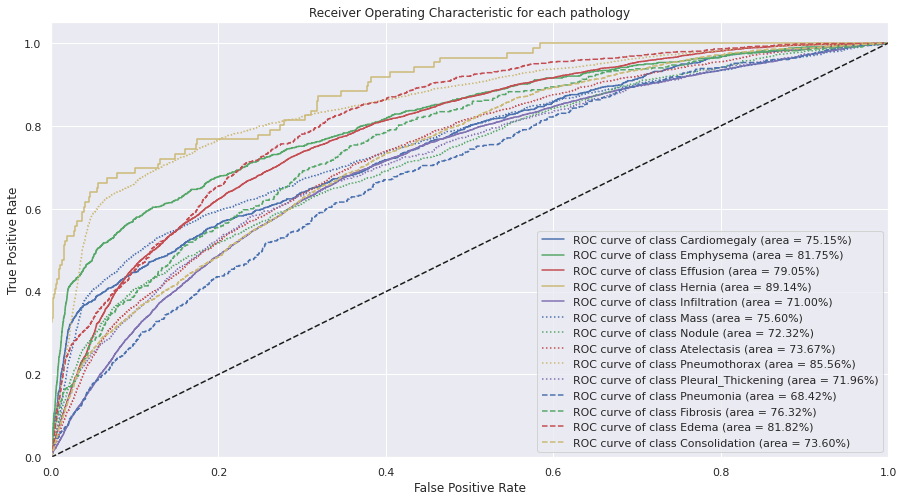

In [118]:
# Plot the ROC curve of each pathology
plot_roc_curves(
    labels, 
    perf_metrics[new_model_name]['fpr'], 
    perf_metrics[new_model_name]['tpr'], 
    perf_metrics[new_model_name]['roc_auc']
)

Based on minimizing the validation loss and maximizing the f1-score, the model with the residual (skip) connection performs the best among the models we investigated.

### Threshold Tuning for Predictions: Maximize F1 Score

In [119]:
filename_thresh = f"{model_hist_path}{new_model_name}_thresh_f1scores.pkl"
with open(filename_thresh, 'rb') as file_pi:
    f1_scores = pickle.load(file_pi)

In [120]:
thresh_by_cat = {k:np.array(list(v.values())).argmax()/100 for k, v in f1_scores.items()}

In [121]:
pd.DataFrame.from_dict(thresh_by_cat, orient='index', columns=['Threshold'])

Threshold
Cardiomegaly             0.74
Emphysema                0.92
Effusion                 0.71
Hernia                   0.92
Infiltration             0.54
Mass                     0.82
Nodule                   0.74
Atelectasis              0.63
Pneumothorax             0.88
Pleural_Thickening       0.79
Pneumonia                0.79
Fibrosis                 0.83
Edema                    0.92
Consolidation            0.80

### Rechecking Model Interpretability: Gradient Flow and Gradcam

In [122]:
idx = []
for l in labels:
    idx.append(data_df_test[data_df_test[l] == 1].sample().index.to_list()[0])

In [123]:
df_sample = data_df_test.loc[idx][['Image Index', 'Finding Labels'] + labels]

In [124]:
img_paths = df_sample.apply(lambda x: f"{img_resized_test}/images/{x['Image Index']}", axis=1).values
y_labels = df_sample[labels].values

In [125]:
# create dataset
gradcam_ds = generate_datasets(
    img_paths, 
    y_labels,
    cat_preds_test,
    batch_size=1, #len(df_sample),
    shuffle=False
)

In [126]:
# create the model and load the weights
model = create_model(new_model)
model.load_weights(f"{model_wts_path}{new_model_name}.h5")

In [127]:
# get last convolutional layer of functional layer
last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
last_conv_layer

'top_conv'

In [128]:
y_preds = model.predict(gradcam_ds)

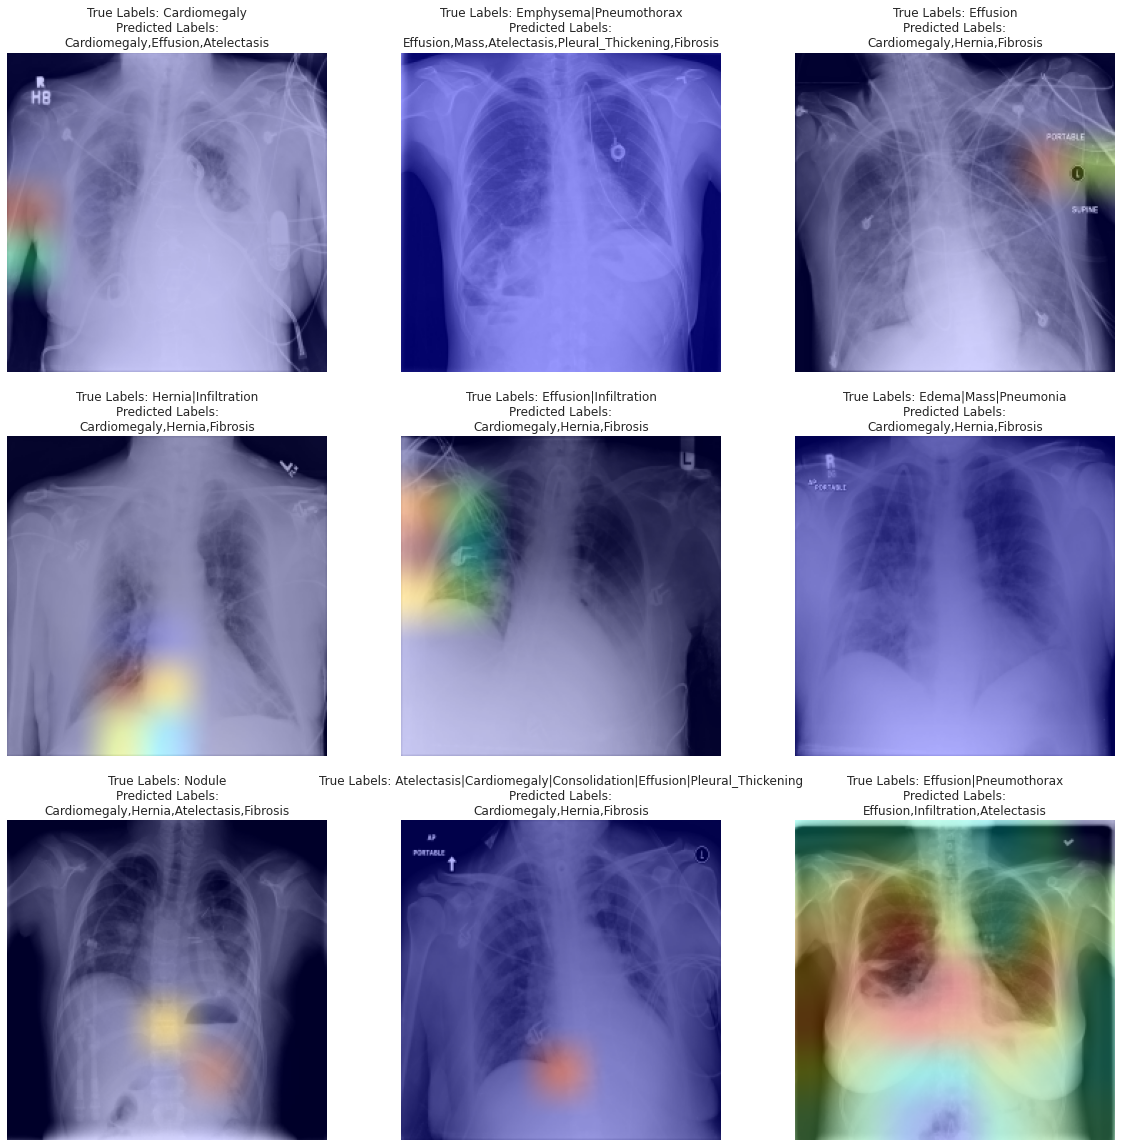

In [129]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

i = 0
for gradcam_imgs, gradcam_y_labels in gradcam_ds.take(9):
    # get heatmap
    hm = make_gradcam_heatmap(gradcam_imgs, model, last_conv_layer)
    img_df = df_sample.iloc[i]
        
    display_gradcam(img_paths[i], hm, axes[i])
    axes[i].grid(False)
    
    axes[i].axis('off')
    
    axes[i].set_title(f"True Labels: {df_sample.iloc[i]['Finding Labels']}\nPredicted Labels:\n{','.join(np.array(labels)[y_preds[i] > list(thresh_by_cat.values())])}")
    
    i += 1


Our intervention has helped - we are now able to see details of learning from CNN layers as an overlay on more images.

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Retraining Model with CNN Layers as Trainable = True
<br />  
    
</div>

We selected this and retrained the whole model, together with the weights of EfficientNetB3, which were set to not trainable in the previous steps,  in order to adjust the weights to our dataset. For this, we used Adam optimizer, with all the default settings, except for the learning ratem which we set to very low value (learning rate = $10^{-6}$). We trained this model for 10 epochs, with a batch size of 32.

In [130]:
sel_model_name = f'FinalModel_{base_model_name}_2D_200E_C_F_Skip'

final_model_name = f'FinalModel_{base_model_name}_2D_200E_C_F_Skip_Retrained'

models[final_model_name] = models[sel_model_name].copy()
final_model = models[final_model_name]
final_model

{'model': 'EfficientNetB3',
 'desc': 'CNN, 2 Dense Layers, 3 Cat Params, Follow Up',
 'preprocess': 'efficientnet',
 'epochs': 200,
 'dense_layers': 2,
 'cat_predictors': 17,
 'datasets': (<BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>,
  <BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>),
 'include_skip': True}

In [131]:
model = create_model(final_model, cnn_layers_trainable=True)
model.load_weights(f"{model_wts_path}{sel_model_name}.h5")

# compile model with very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-6), 
    loss=get_weighted_loss(pos_weights, neg_weights), 
    metrics=['accuracy']
)

In [132]:
cat_preds_train = cat_df_w_follow.values if final_model.get('cat_predictors', 0) > 3 else cat_df.values if final_model.get('cat_predictors', 0) > 0 else np.array([])

In [133]:
new_batch_size = 32
new_val_split = 0.5

models[final_model_name]['datasets'] = get_datasets(
    img_resized_train, 
    data_df_train[labels].values, 
    cat_preds_train, 
    batch_size=new_batch_size, 
    val_split=new_val_split
)

final_model = models[final_model_name]

Found 86524 files belonging to 1 classes.


In [134]:
K.clear_session()
if os.path.exists(f"{model_hist_path}{final_model_name}.pkl"):
    # we've completed this one... let's keep going
    with open(f"{model_hist_path}{final_model_name}.pkl", 'rb') as file_pi:
        model_hists[final_model_name] = pickle.load(file_pi)
    print(f"Skipping {final_model_name} since this is already completed.")
else:
    # get relevant datasets
    inputs_train = final_model['datasets'][0]
    inputs_val = final_model['datasets'][1]

    # preprocess train and test sets if required
    if final_model.get('cat_predictors', 0) > 0:
        # handle that the input will have an additional array
        func = lambda x, y: ((eval('tf.keras.applications.' + final_model['preprocess'] + '.preprocess_input')(x[0]), x[1]), y)
    else:
        func = lambda x, y: (eval('tf.keras.applications.' + final_model['preprocess'] + '.preprocess_input')(x), y)

    if final_model.get('preprocess', False):
        inputs_train = inputs_train.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        inputs_val = inputs_val.map(func, num_parallel_calls=tf.data.AUTOTUNE)

    inputs_train = inputs_train.prefetch(tf.data.AUTOTUNE)
    inputs_val = inputs_val.prefetch(tf.data.AUTOTUNE)

    print(f"All ready! Starting fit!")
    # model.summary()
    hist = model.fit(
      inputs_train,
      batch_size=new_batch_size,
      epochs= 10,
      validation_data=inputs_val,
      verbose=True,
      callbacks=[es]
    )

    model_hists[final_model_name] = hist.history
    
    model.save_weights(f"{model_wts_path}{final_model_name}.h5")

    min_loss_idx = np.argmin(hist.history['val_loss'])

    with open(f"{model_hist_path}{final_model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

    print(f"Completed training of {final_model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


Skipping FinalModel_EfficientNetB3_2D_200E_C_F_Skip_Retrained since this is already completed.


In [135]:
cat_preds_test = cat_df_test_w_follow.values if final_model.get('cat_predictors', 0) > 3 else cat_df_test.values if final_model.get('cat_predictors', 0) > 0 else np.array([])

In [136]:
filename = f"{model_hist_path}{final_model_name}_c_report.pkl"
filename_thresh = f"{model_hist_path}{final_model_name}_thresh_f1scores.pkl"
if os.path.exists(filename) and os.path.exists(filename_thresh):
    # we've completed this one... let's keep going
    with open(filename, 'rb') as file_pi:
        perf_metrics[final_model_name] = pickle.load(file_pi)
    with open(filename_thresh, 'rb') as file_pi:
        f1_scores = pickle.load(file_pi)
    print(f"Loaded {final_model_name} metrics from pickle file")
else:
    # get dataset for test df
    images_test = get_datasets(
        img_dir=img_resized_test, 
        labels=data_df_test[labels].values,
        cat_inputs = cat_preds_test,
        val_split=0,
        shuffle=False
    )
    
    y_true = data_df_test[labels].values
    y_pred = model.predict(images_test)
    
    perf_metrics[final_model_name] = get_performance_metrics(y_true, y_pred, labels, plot_curves=False)
    
    # get f1-scores at each threshold
    f1_scores = tune_threshold(y_true, y_pred, labels)
    
    # store both files
    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics[final_model_name], file_pi)
    with open(filename_thresh, 'wb') as file_pi:
        pickle.dump(f1_scores, file_pi)

Loaded FinalModel_EfficientNetB3_2D_200E_C_F_Skip_Retrained metrics from pickle file


In [137]:
# calculating sensitivity and specificity for each model
sens_spec = {}

for model_name in models.keys():
    sensitivity, specificity = calculate_sensitivity_specificity(perf_metrics[model_name]['conf_matrix'])

    sens_spec[model_name] = {'sensitivity': sensitivity, 'specificity': specificity}

In [138]:
# Dataframe to plot senitivity/specificity per model
sens_spec_df = pd.DataFrame(sens_spec).T.explode(['sensitivity', 'specificity']).reset_index().melt(id_vars=['index'])
sens_spec_df = sens_spec_df.rename(columns={'variable':'metric', 'index':'model'})

# To compare the models, we use the weighted average of the accuracy metrics provided by sklearn.metrics.classification_report
f1_w = dict()

for model_name in models.keys():
    f1_w[model_name] = perf_metrics[model_name]['class_rep']['weighted avg']
    
    min_loss_idx = np.argmin(model_hists[model_name]['val_loss'])
    f1_w[model_name]['val_accuracy'] = model_hists[model_name]['val_accuracy'][min_loss_idx]
    f1_w[model_name]['val_loss'] = model_hists[model_name]['val_loss'][min_loss_idx]
    if 'support' in  f1_w[model_name]:
        del f1_w[model_name]['support']

# Dataframe to plot other performance metrics per model
cr_df = pd.DataFrame(f1_w).T.reset_index().melt(id_vars=['index']).rename(columns={'index':'model', 'variable':'metric'})

### Performance comparison of all models

The graph below shows the performance of all 6 models that were described above, and it is obvious that the model with all categorical variables, skip connection and retrained weights of EfficientNetB3 has the highest performance.

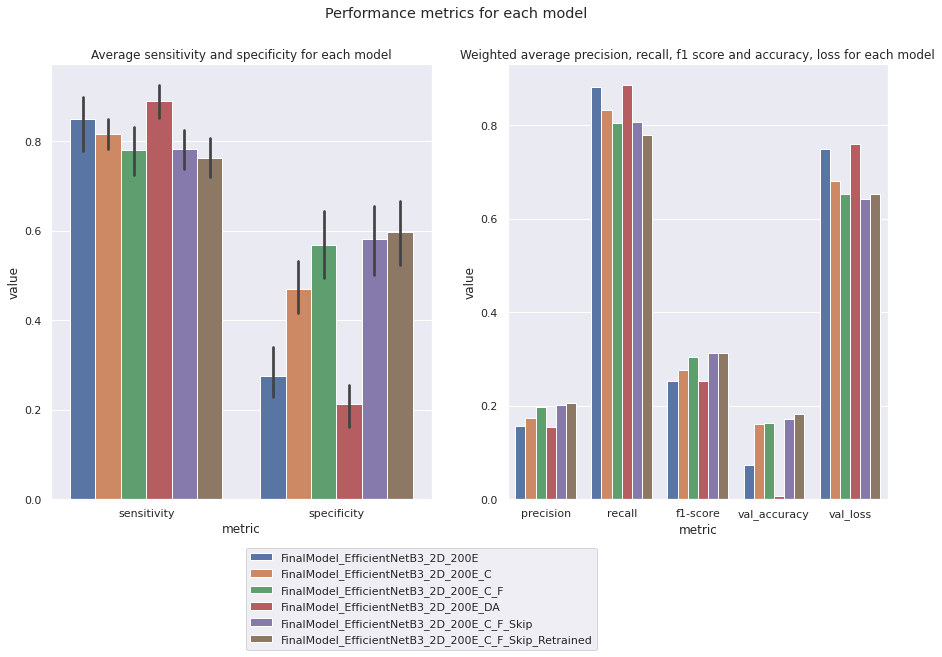

In [139]:
fig, ax = plt.subplots(1,2)
sns.barplot(x="metric", y="value", hue="model", data=sens_spec_df, ax=ax[0])
sns.barplot(x="metric", y="value", hue="model", data=cr_df, ax=ax[1])
ax[0].set(title='Average sensitivity and specificity for each model')
ax[1].set(title='Weighted average precision, recall, f1 score and accuracy, loss for each model')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.25,-0.1), loc="upper right")
plt.suptitle('Performance metrics for each model')
plt.show()

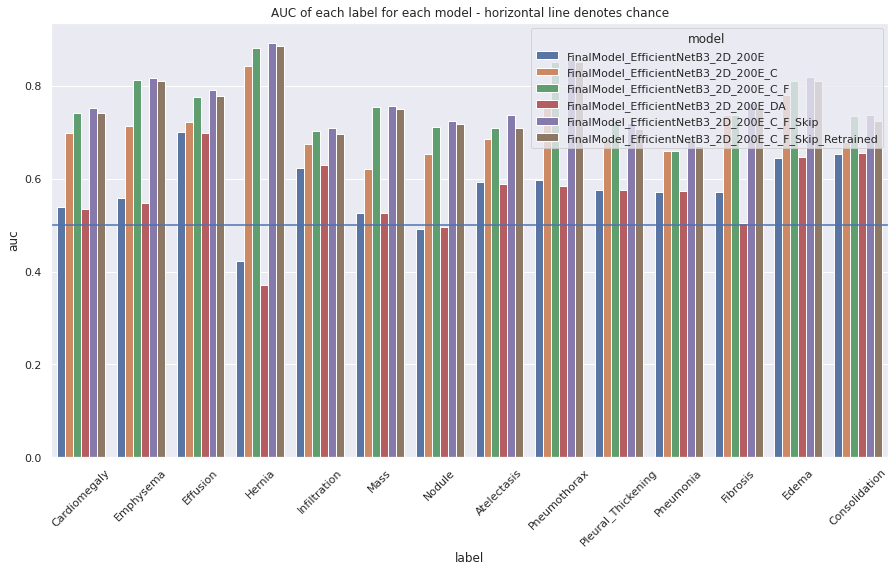

In [140]:
auc_vals = {k:v['roc_auc'] for k, v in perf_metrics.items()}
auc_df = pd.DataFrame(auc_vals).T.reset_index().melt(id_vars='index').rename(columns={'index':'model', 'variable':'label', 'value':'auc'})

bp = sns.barplot(data=auc_df, x='label', y='auc', hue='model')
bp.axhline(0.5)
plt.xticks(rotation=45)
plt.title('AUC of each label for each model - horizontal line denotes chance')
plt.show()


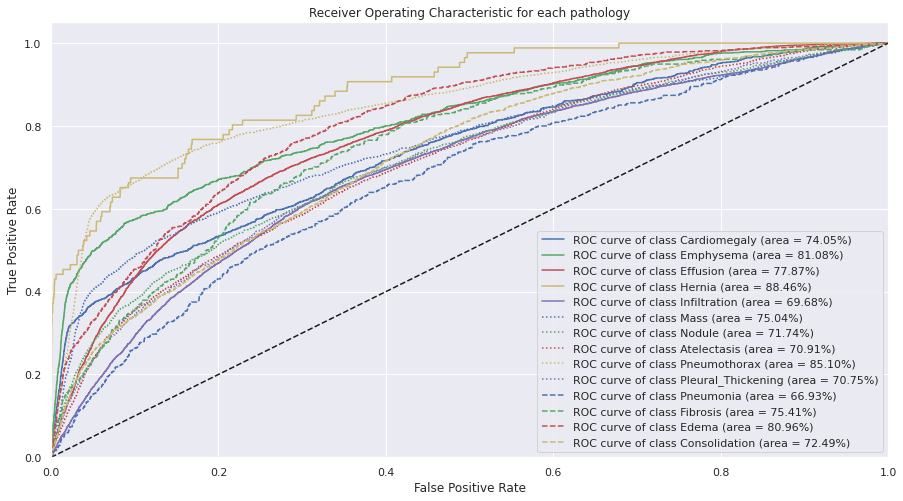

In [141]:
# Plot the ROC curve of each pathology
plot_roc_curves(
    labels, 
    perf_metrics[final_model_name]['fpr'], 
    perf_metrics[final_model_name]['tpr'], 
    perf_metrics[final_model_name]['roc_auc']
)

It is obvious from the graph that the model performs well for all labels, as all curves are above the diagonal line. The AUC values vary between 0.67 for Pneumonia and 0.88 for Hernia. Interestingly, we found that the number of images does not appear to be correlated with the AUC. This explains the differences in AUC values between these two labels, which have the lowest frequency in the dataset.

### Threshold Tuning for Predictions: Maximize F1 Score

In [142]:
filename_thresh = f"{model_hist_path}{final_model_name}_thresh_f1scores.pkl"
with open(filename_thresh, 'rb') as file_pi:
    f1_scores = pickle.load(file_pi)

In [143]:
thresh_by_cat = {k:np.array(list(v.values())).argmax()/100 for k, v in f1_scores.items()}

In [144]:
pd.DataFrame.from_dict(thresh_by_cat, orient='index', columns=['Threshold'])

Threshold
Cardiomegaly             0.80
Emphysema                0.91
Effusion                 0.74
Hernia                   0.92
Infiltration             0.53
Mass                     0.83
Nodule                   0.72
Atelectasis              0.64
Pneumothorax             0.87
Pleural_Thickening       0.75
Pneumonia                0.74
Fibrosis                 0.84
Edema                    0.91
Consolidation            0.80

### Model Interpretability: Gradcam

To review what the network focuses on to make a prediction, we used Gradcam on random images from the test set.

In [145]:
idx = []
for l in labels:
    idx.append(data_df_test[data_df_test[l] == 1].sample().index.to_list()[0])

In [146]:
df_sample = data_df_test.loc[idx][['Image Index', 'Finding Labels'] + labels]

In [147]:
img_paths = df_sample.apply(lambda x: f"{img_resized_test}/images/{x['Image Index']}", axis=1).values
y_labels = df_sample[labels].values

In [148]:
# create dataset
gradcam_ds = generate_datasets(
    img_paths, 
    y_labels,
    cat_preds_test,
    batch_size=1, #len(df_sample),
    shuffle=False
)

In [149]:
# create the model and load the weights
model = create_model(final_model)
model.load_weights(f"{model_wts_path}{final_model_name}.h5")

In [150]:
# get last convolutional layer of functional layer
last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
last_conv_layer

'top_conv'

In [151]:
y_preds = model.predict(gradcam_ds)

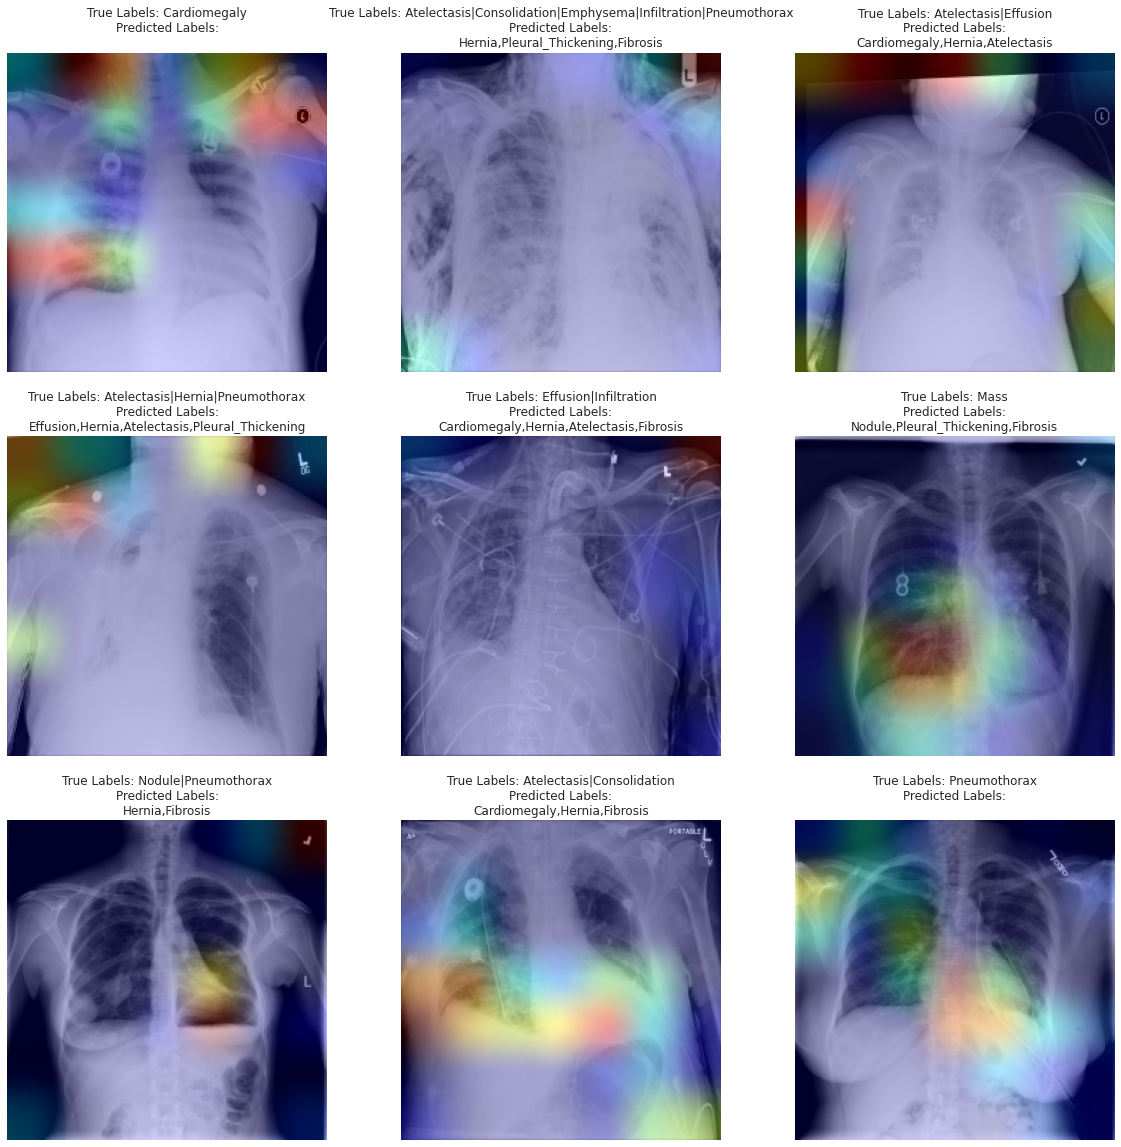

In [152]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

i = 0
for gradcam_imgs, gradcam_y_labels in gradcam_ds.take(9):
    # get heatmap
    hm = make_gradcam_heatmap(gradcam_imgs, model, last_conv_layer)
    img_df = df_sample.iloc[i]
 
    display_gradcam(img_paths[i], hm, axes[i])
    axes[i].grid(False)
    
    axes[i].axis('off')
    
    axes[i].set_title(f"True Labels: {df_sample.iloc[i]['Finding Labels']}\nPredicted Labels:\n{','.join(np.array(labels)[y_preds[i] > list(thresh_by_cat.values())])}")
    
    i += 1


### Model Interpretability: Comparing Gradcam output with Bounding Boxes

To further understand our prediction accuracy and what the network focuses on to make a prediction, we used Gradcam on random images from the test set while super-imposing bounding boxes, to compare the network focus to the bounding box.

In [153]:
df_sample = boxes.groupby('Finding Label').sample()

In [154]:
df_sample = df_sample.merge(data_df_test[['Image Index'] + labels], how='left', left_on='Image Index', right_on='Image Index')

In [155]:
img_paths = df_sample.apply(lambda x: f"{img_resized_test}/images/{x['Image Index']}", axis=1).values
y_labels = df_sample[labels].values

In [156]:
# create dataset
gradcam_ds = generate_datasets(
    img_paths, 
    y_labels,
    cat_preds_test,
    batch_size=1,
    shuffle=False
)

In [157]:
# create the model and load the weights
model = create_model(final_model)
model.load_weights(f"{model_wts_path}{final_model_name}.h5")

In [158]:
# get last convolutional layer of functional layer
last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
last_conv_layer

'top_conv'

In [159]:
y_preds = model.predict(gradcam_ds)

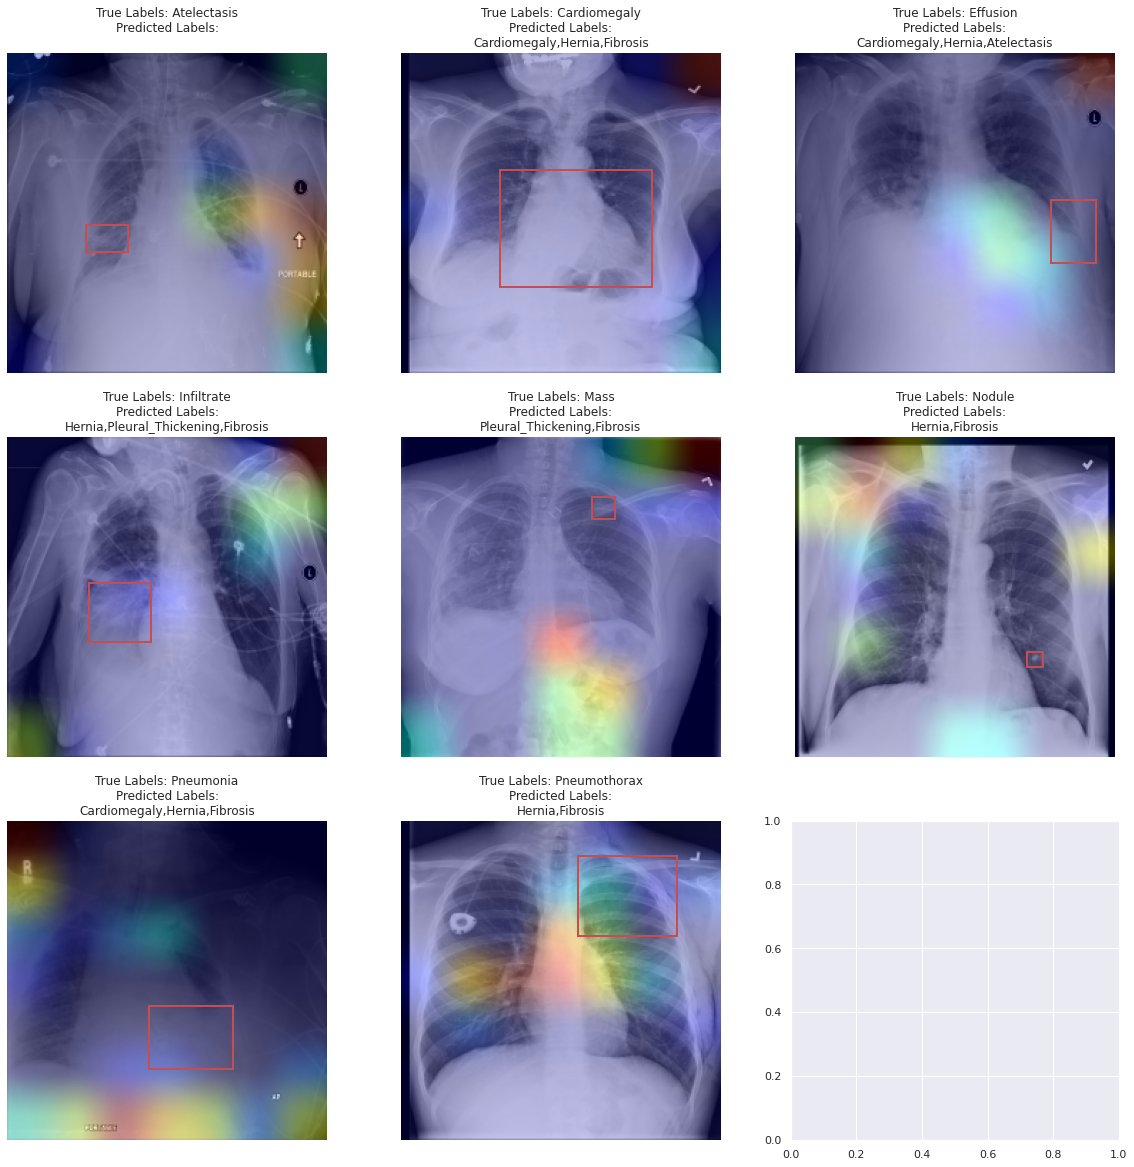

In [160]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

box_scaler = 1 * 224 / 1024 # since we scaled down the images to 224, 224

i = 0
for gradcam_imgs, gradcam_y_labels in gradcam_ds.take(8):
    # get heatmap
    hm = make_gradcam_heatmap(gradcam_imgs, model, last_conv_layer)
    img_df = df_sample.iloc[i]
    
    display_gradcam(img_paths[i], hm, axes[i])
    axes[i].grid(False)
    rect = patches.Rectangle(
        (img_df['x'] * box_scaler, img_df['y'] * box_scaler),
        img_df['w'] * box_scaler,
        img_df['h'] * box_scaler,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    axes[i].add_patch(rect)
    
    axes[i].axis('off')
    
    axes[i].set_title(f"True Labels: {df_sample.iloc[i]['Finding Label']}\nPredicted Labels:\n{','.join(np.array(labels)[y_preds[i] > list(thresh_by_cat.values())])}")
    
    i += 1


We see, via the Grad-cam overlays, that the focus areas for the model are similar to locations of the bounding boxes in some cases. That said, the accuracy of the model is rudimentary at best and more needs to be done to improve the same.

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

# Final Reflections
<br />  
    
</div>

For this project, we worked with a large dataset of chest X-ray images and the accompanying patient and image information, to predict the pathologies/labels assigned to each X-ray image. This was a multiclass problem, as there were 15 labels in total, as well as a multi-label problem, as one image could be associated with multiple labels. The dataset was proven to be highly imbalanced with almost half the images classified as “No Finding”.

To address the complexity of the task, we used a custom loss function that minimizes the total average loss. Instead of designing and training a deep neural network from scratch, we used transfer learning and compared 6 pretrained state-of-the art models. We investigated a few different architectures and we concluded that using EfficientNetB3 for the convolutional part of the network, in combination with patient and image characteristics and a residual connection between the Dense layers and the last Convolutional  layer produced the lowest validation loss. We then proceeded to train the weights of EfficientNetB3, which further improved our validation loss and f1-score. Finally, we used Gradcam to visualize what our model focuses on to make a prediction.

Despite the satisfactory metric values of our model, the accuracy is not very high. We had several thoughts regarding steps that could be taken to improve the accuracy of the classifier, namely,

- First of all, we could not perform an extensive data augmentation encompassing all pathologies due to limited time, but in the future, data augmentation could be performed for all labels, and potentially, the “No Finding” label could be undersampled.
- Also, potentially, an alternative approach to the custom loss function could be introduced in order to increase the model accuracy.
- Bounding boxes could be made available in the training set to provide better guidance to the model.
- Finally, additional patient information, such as medical history and symptoms, among others, would bring very powerful information to help the model make better predictions.

--

#### References

1. X. Wang, Y. Peng, L. Lu, Z. Lu, M. Bagheri, and R. Summers. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. In CVPR, 2017. https://arxiv.org/abs/1705.02315.
1. https://radiopaedia.org/articles/chest-ap-erect-view-1
1.  Irvin et al, CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison, 2-019, arXiv:1901.07031
1. https://keras.io/api/applications/